<a href="https://colab.research.google.com/github/Nitecry7/FPL-Neural-Networks-Project/blob/main/FPL_Neural_Networks_Project_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting FPL Player Points (2024–25) with Neural Networks

## Goal

Given historical Fantasy Premier League (FPL) data up to gameweek \(t-1\), we want to predict a player's FPL points in gameweek \(t\).

Each training example is **one (player, gameweek)** pair. The task is a **regression** problem: predict a real–valued number of FPL points.

## Data source

The data comes from the public GitHub repository **“FPL Elo Insights”** (Olbauday): `https://github.com/olbauday/FPL-Elo-Insights`

- `players.csv` – one row per FPL player with *static* information  
  (e.g. `player_id`, `web_name`, `position`, `team_code`).
- `teams.csv` – one row per team with *team strength* information  
  (e.g. `name`, `short_name`, `strength_*`, `elo`).
- `playerstats.csv` – one row per **(player, gameweek)** with *performance statistics*  
  (e.g. `gw`, `event_points`, `minutes`, `ict_index`, `transfers_in_event`, `expected_goal_involvements_per_90`, …).

In this notebook we:

1. **Merge** these three files into a single modelling table, so that each row contains:
   - player identity (name, position, team),
   - team strength / Elo,
   - per–gameweek FPL stats and advanced metrics.

2. **Engineer time-aware features** that capture recent form:
   - previous gameweek points,
   - rolling 3–game averages of points, xGI per 90, and ICT index,
   - net transfers (in − out),
   - previous minutes.

3. Create **time-based splits** `50-25-25`:
   - Train: gameweeks 4–20  
   - Validation: gameweeks 21–29  
   - Test: gameweeks 30–38  
   so that we always **predict the future from the past** (no data leakage).

4. Train and compare:
   - a simple **baseline** (last 3-gameweek average points),
   - a **Multilayer Perceptron (MLP)** on tabular features,
   - a **sequence LSTM** with 5-gameweek history,
   - a **sequence GRU** with 5-gameweek history.

5. Evaluate all models using **MAE** and **RMSE**, and analyse error patterns and case studies for selected players (Haaland, Salah, Saka).


## Setup & Imports

In [1]:
# ==========================
# Basic setup and libraries
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Nicer Pandas display
pd.set_option("display.max_columns", 150)
pd.set_option("display.width", 200)

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries imported.")


Libraries imported.


## 1. Loading the Raw FPL Data

We work with three CSV files:

- **`players.csv`**  
  One row per FPL player with metadata, for example:  
  `player_id`, `player_code`, `web_name`, `team_code`, `position`, etc.

- **`teams.csv`**  
  One row per team with team-level information:  
  `id`, `code`, `name`, `short_name`, `strength_*`, `elo`, etc.

- **`playerstats.csv`**  
  One row per **(player, gameweek)** with their performance stats:  
  `player_id` (or `id`), `gw`, `event_points`, `minutes`, `ict_index`,  
  `transfers_in_event`, `transfers_out_event`, and possibly advanced stats like  
  `expected_goal_involvements_per_90`.

We will:

1. Upload these three CSVs into Colab.
2. Load them into Pandas DataFrames.
3. Inspect shapes and the first few rows to confirm structure.


In [2]:
from google.colab import files

print("Please select the CSV files (players.csv, teams.csv, playerstats.csv) to upload:")
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Please select the CSV files (players.csv, teams.csv, playerstats.csv) to upload:


Saving players.csv to players (4).csv
Saving playerstats.csv to playerstats (4).csv
Saving teams.csv to teams (4).csv
User uploaded file "players (4).csv" with length 39335 bytes
User uploaded file "playerstats (4).csv" with length 5723303 bytes
User uploaded file "teams (4).csv" with length 1363 bytes


In [3]:

players = pd.read_csv('players.csv')
teams = pd.read_csv('teams.csv')
playerstats = pd.read_csv('playerstats.csv')

print("players:", players.shape)
print("teams:", teams.shape)
print("playerstats:", playerstats.shape)

display(players.head())
display(teams.head())
display(playerstats.head())


players: (804, 7)
teams: (20, 13)
playerstats: (27657, 58)


,player_code,player_id,first_name,second_name,web_name,team_code,position
0,438098,1,Fabio,Ferreira Vieira,Fábio Vieira,3,Midfielder
1,100051017,735,Mikel,Arteta,Arteta,3,Unknown
2,616059,756,Jack,Porter,Porter,3,Goalkeeper
3,538182,790,Jimi,Gower,Gower,3,Midfielder
4,514307,793,Jack,Henry-Francis,Jack Henry-Francis,3,Midfielder


,code,id,name,short_name,strength,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id,elo
0,3,1,Arsenal,ARS,5,1350,1350,1390,1400,1310,1300,1,1991
1,7,2,Aston Villa,AVL,3,1145,1240,1130,1180,1160,1300,2,1870
2,91,3,Bournemouth,BOU,3,1170,1200,1120,1180,1220,1220,127,1806
3,94,4,Brentford,BRE,3,1130,1180,1100,1100,1160,1260,130,1809
4,36,5,Brighton,BHA,3,1140,1165,1090,1140,1190,1190,131,1825


,id,status,chance_of_playing_next_round,chance_of_playing_this_round,now_cost,now_cost_rank,now_cost_rank_type,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,selected_by_percent,selected_rank,selected_rank_type,total_points,event_points,points_per_game,points_per_game_rank,points_per_game_rank_type,bonus,bps,form,form_rank,form_rank_type,value_form,value_season,dreamteam_count,transfers_in,transfers_in_event,transfers_out,transfers_out_event,ep_next,ep_this,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,influence,influence_rank,influence_rank_type,creativity,creativity_rank,creativity_rank_type,threat,threat_rank,threat_rank_type,ict_index,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,direct_freekicks_order,penalties_order,gw,set_piece_threat
0,5,u,0.0,0.0,4.0,645,55,0,0,0,0,0.0,602,69,0,0,0.0,573,63,0,0,0.0,464,53,0.0,0.0,0,0,0,4399,20,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,566,63,0.0,549,45,0.0,512,31,0.0,566,63,NaN,NaN,NaN,23,NaN
1,6,a,100.0,100.0,5.6,100,10,0,0,1,-1,4.4,83,30,72,5,3.6,83,18,5,274,2.0,178,56,0.4,12.9,2,1220019,9591,879735,49584,2.0,2.5,0.71,1.01,1.72,14.70,0.04,0.05,0.09,0.79,270.2,168,62,220.1,122,25,172.0,130,14,66.0,136,35,NaN,NaN,NaN,23,NaN
2,7,a,100.0,100.0,4.7,323,209,0,0,-3,3,0.2,342,109,13,0,1.3,372,173,0,82,0.5,328,155,0.1,2.8,0,28956,538,46162,674,0.5,1.0,0.04,0.47,0.51,4.27,0.01,0.09,0.10,0.84,35.8,398,179,64.7,280,171,3.0,421,221,10.4,384,187,NaN,NaN,NaN,23,NaN
3,8,a,NaN,NaN,4.8,314,40,0,0,-2,2,0.2,383,132,13,0,1.6,327,106,0,39,0.0,685,241,0.0,2.7,0,25166,184,35333,549,0.0,0.5,0.00,0.03,0.03,4.45,0.00,0.01,0.01,1.24,49.2,383,133,13.7,392,135,0.0,707,249,6.3,415,139,NaN,NaN,NaN,23,NaN
4,9,a,100.0,100.0,6.7,38,19,0,0,-3,3,3.4,97,29,84,3,4.0,56,29,6,268,3.0,119,51,0.4,12.5,1,1099050,10248,1081194,41041,3.0,3.5,3.87,2.90,6.77,13.94,0.26,0.19,0.45,0.92,366.2,104,38,334.6,65,49,547.0,26,14,124.7,37,25,NaN,NaN,NaN,23,NaN


## 1. Inspecting the raw tables

Before merging, we briefly check the three source tables:

- `players` has one row per player (804 rows), mostly static information.
- `teams` has one row per team (20 rows) with strength and Elo ratings.
- `playerstats` has one row per (player, gameweek) with 27k+ rows.  
  This table contains our **target variable** `event_points` and other per-GW statistics.

We will:

1. Align the player IDs between `playerstats` and `players`.
2. Join team information into `playerstats` via `team_code`.
3. Verify that **gameweek (`gw`)** and **FPL points (`event_points`)** are present and numeric.


## 2. Merging player, team and per–gameweek stats

After renaming `playerstats.id → player_id` (when necessary), we:

1. Join `playerstats` ↔ `players` on `player_id` to add:
   - `web_name` (for readability),
   - `position` (GK / DEF / MID / FWD),
   - `team_code`.

2. Join the result ↔ `teams` on `team_code == code` to add:
   - attack / defence strengths (home and away),
   - overall team strength,
   - **Elo rating** as a compact team–strength summary.

We then:

- ensure `gw` (gameweek) and `event_points` are numeric,
- drop rows where either is missing (future GWs or invalid rows),
- inspect one player’s time series to confirm that the **(player, gw)** structure looks reasonable.

At this point, each row of `data` = one **(player, gameweek)** with:
- identifier columns (`player_id`, `web_name`, `gw`),
- FPL performance metrics (`event_points`, `minutes`, `ict_index`, …),
- team-strength features (`strength_*`, `elo`),
- various FPL popularity and value metrics.


In [4]:
# =======================================================
# 2.1 Rename playerstats.id -> player_id (if necessary)
# =======================================================
if "id" in playerstats.columns and "player_id" not in playerstats.columns:
    playerstats = playerstats.rename(columns={"id": "player_id"})

assert "player_id" in playerstats.columns, "Could not find 'player_id' in playerstats!"

# Minimal columns from players that we care about
player_cols = ["player_id", "player_code", "web_name", "team_code", "position"]
player_cols = [c for c in player_cols if c in players.columns]  # keep only existing
players_subset = players[player_cols].copy()

print("players_subset columns:", players_subset.columns.tolist())

# Merge playerstats + players on player_id
data = playerstats.merge(players_subset, on="player_id", how="left")

# Team columns we care about
team_cols = [
    "id", "code", "name", "short_name",
    "strength",
    "strength_overall_home", "strength_overall_away",
    "strength_attack_home", "strength_attack_away",
    "strength_defence_home", "strength_defence_away",
    "elo"
]
team_cols = [c for c in team_cols if c in teams.columns]
teams_subset = teams[team_cols].copy()

print("teams_subset columns:", teams_subset.columns.tolist())

# Merge with teams: player team_code vs teams.code
data = data.merge(
    teams_subset,
    left_on="team_code",
    right_on="code",
    how="left",
    suffixes=("", "_team")
)

print("Merged data shape:", data.shape)
display(data.head())


players_subset columns: ['player_id', 'player_code', 'web_name', 'team_code', 'position']
teams_subset columns: ['id', 'code', 'name', 'short_name', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'elo']
Merged data shape: (27657, 74)


,player_id,status,chance_of_playing_next_round,chance_of_playing_this_round,now_cost,now_cost_rank,now_cost_rank_type,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,selected_by_percent,selected_rank,selected_rank_type,total_points,event_points,points_per_game,points_per_game_rank,points_per_game_rank_type,bonus,bps,form,form_rank,form_rank_type,value_form,value_season,dreamteam_count,transfers_in,transfers_in_event,transfers_out,transfers_out_event,ep_next,ep_this,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,expected_goals_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,influence,influence_rank,influence_rank_type,creativity,creativity_rank,creativity_rank_type,threat,threat_rank,threat_rank_type,ict_index,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,direct_freekicks_order,penalties_order,gw,set_piece_threat,player_code,web_name,team_code,position,id,code,name,short_name,strength,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,elo
0,5,u,0.0,0.0,4.0,645,55,0,0,0,0,0.0,602,69,0,0,0.0,573,63,0,0,0.0,464,53,0.0,0.0,0,0,0,4399,20,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,566,63,0.0,549,45,0.0,512,31,0.0,566,63,NaN,NaN,NaN,23,NaN,463748,Hein,3,Goalkeeper,1,3,Arsenal,ARS,5,1350,1350,1390,1400,1310,1300,1991
1,6,a,100.0,100.0,5.6,100,10,0,0,1,-1,4.4,83,30,72,5,3.6,83,18,5,274,2.0,178,56,0.4,12.9,2,1220019,9591,879735,49584,2.0,2.5,0.71,1.01,1.72,14.70,0.04,0.05,0.09,0.79,270.2,168,62,220.1,122,25,172.0,130,14,66.0,136,35,NaN,NaN,NaN,23,NaN,445122,J.Timber,3,Defender,1,3,Arsenal,ARS,5,1350,1350,1390,1400,1310,1300,1991
2,7,a,100.0,100.0,4.7,323,209,0,0,-3,3,0.2,342,109,13,0,1.3,372,173,0,82,0.5,328,155,0.1,2.8,0,28956,538,46162,674,0.5,1.0,0.04,0.47,0.51,4.27,0.01,0.09,0.10,0.84,35.8,398,179,64.7,280,171,3.0,421,221,10.4,384,187,NaN,NaN,NaN,23,NaN,85955,Jorginho,3,Midfielder,1,3,Arsenal,ARS,5,1350,1350,1390,1400,1310,1300,1991
3,8,a,NaN,NaN,4.8,314,40,0,0,-2,2,0.2,383,132,13,0,1.6,327,106,0,39,0.0,685,241,0.0,2.7,0,25166,184,35333,549,0.0,0.5,0.00,0.03,0.03,4.45,0.00,0.01,0.01,1.24,49.2,383,133,13.7,392,135,0.0,707,249,6.3,415,139,NaN,NaN,NaN,23,NaN,440854,Kiwior,3,Defender,1,3,Arsenal,ARS,5,1350,1350,1390,1400,1310,1300,1991
4,9,a,100.0,100.0,6.7,38,19,0,0,-3,3,3.4,97,29,84,3,4.0,56,29,6,268,3.0,119,51,0.4,12.5,1,1099050,10248,1081194,41041,3.0,3.5,3.87,2.90,6.77,13.94,0.26,0.19,0.45,0.92,366.2,104,38,334.6,65,49,547.0,26,14,124.7,37,25,NaN,NaN,NaN,23,NaN,444145,Martinelli,3,Midfielder,1,3,Arsenal,ARS,5,1350,1350,1390,1400,1310,1300,1991


In [5]:
# Show columns
print("Columns in merged data:")
print(sorted(data.columns))

# Make sure key columns exist
assert "gw" in data.columns, "Expected column 'gw' (gameweek) not found!"
assert "event_points" in data.columns, "Expected column 'event_points' not found!"

# Ensure gw and event_points are numeric
data["gw"] = pd.to_numeric(data["gw"], errors="coerce")
data["event_points"] = pd.to_numeric(data["event_points"], errors="coerce")

# Drop rows without gw or event_points
data = data.dropna(subset=["gw", "event_points"]).copy()
data["gw"] = data["gw"].astype(int)

print("After cleaning gw/event_points, data shape:", data.shape)

# Inspect one example player's time series
inspect_cols = ["player_id", "web_name", "gw", "event_points", "minutes", "form", "ict_index"]
inspect_cols = [c for c in inspect_cols if c in data.columns]

example_player_id = data["player_id"].iloc[0]
print("Example player_id:", example_player_id)

display(
    data.loc[data["player_id"] == example_player_id, inspect_cols]
        .sort_values("gw")
        .head(10)
)

# Quick missing-values check in a few numeric columns
numeric_cols_to_check = ["event_points", "minutes", "ict_index"]
numeric_cols_to_check = [c for c in numeric_cols_to_check if c in data.columns]

print("\nMissing values in key numeric columns:")
print(data[numeric_cols_to_check].isna().sum())


Columns in merged data:
['bonus', 'bps', 'chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'corners_and_indirect_freekicks_order', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'creativity', 'creativity_rank', 'creativity_rank_type', 'direct_freekicks_order', 'dreamteam_count', 'elo', 'ep_next', 'ep_this', 'event_points', 'expected_assists', 'expected_assists_per_90', 'expected_goal_involvements', 'expected_goal_involvements_per_90', 'expected_goals', 'expected_goals_conceded', 'expected_goals_conceded_per_90', 'expected_goals_per_90', 'form', 'form_rank', 'form_rank_type', 'gw', 'ict_index', 'ict_index_rank', 'ict_index_rank_type', 'id', 'influence', 'influence_rank', 'influence_rank_type', 'name', 'now_cost', 'now_cost_rank', 'now_cost_rank_type', 'penalties_order', 'player_code', 'player_id', 'points_per_game', 'points_per_game_rank', 'points_per_game_rank_type', 'position', 'selected_by_percent', 'selected_rank',

,player_id,web_name,gw,event_points,form,ict_index
18646,5,Hein,1,0,0.0,0.0
18019,5,Hein,2,0,0.0,0.0
17366,5,Hein,3,0,0.0,0.0
16709,5,Hein,4,0,0.0,0.0
16050,5,Hein,5,0,0.0,0.0
15398,5,Hein,6,0,0.0,0.0
14727,5,Hein,7,0,0.0,0.0
12172,5,Hein,8,0,0.0,0.0
14733,5,Hein,9,0,0.0,0.0
12210,5,Hein,10,0,0.0,0.0



Missing values in key numeric columns:
event_points    0
ict_index       0
dtype: int64


## 4. Step 2 — Feature Engineering: Lag and Rolling Form Features

Neural networks work best when we give them **meaningful, informative inputs**.

Instead of only using raw stats from the current gameweek, we want to encode a notion of **recent form**:

- Is the player currently performing well?
- Are they consistently getting minutes?
- Are FPL managers buying or selling them heavily?

To capture this, we:

1. **Sort** the table by `player_id` and `gw` so that each player's matches are in time order.
2. For each player separately, create **lagged and rolling features** such as:
   - `event_points_prev1`: FPL points in the **previous gameweek** (t−1).
   - `avg_points_last3`: average FPL points over the **last 3 gameweeks**, using only past data.
   - `avg_xgi_per90_last3`: rolling mean of `expected_goal_involvements_per_90` over the last 3 GWs (if present).
   - `avg_ict_last3`: rolling mean of `ict_index` over the last 3 GWs (if present).
   - `net_transfers_event`: `transfers_in_event - transfers_out_event` (how popular the player is for this GW).
   - `minutes_prev1`: minutes played in the previous GW.

3. **Filter out early gameweeks** where we do not have enough history (e.g. fewer than 3 previous GWs).

The resulting DataFrame `modelling_data` will be the **core table** used later for:

- The **baseline** model,
- The **MLP** (using tabular features),
- And building sequences for **LSTM** and **GRU**.


In [6]:
# ===============================================
# 4.1 Create lagged & rolling form features
# ===============================================

# Sort by player and gameweek to respect time order
data = data.sort_values(["player_id", "gw"]).copy()

# Group by player for time-based operations
grouped = data.groupby("player_id", group_keys=False)

# 1) Previous gameweek points
data["event_points_prev1"] = grouped["event_points"].shift(1)

# 2) Rolling average of last 3 gameweeks' points (using only past data)
data["avg_points_last3"] = (
    grouped["event_points"]
    .shift(1)                        # shift by 1 to avoid including current gw
    .rolling(window=3, min_periods=3)
    .mean()
)

# 3) Rolling average of xGI per 90 over last 3 GWs
if "expected_goal_involvements_per_90" in data.columns:
    data["avg_xgi_per90_last3"] = (
        grouped["expected_goal_involvements_per_90"]
        .shift(1)
        .rolling(window=3, min_periods=3)
        .mean()
    )
else:
    print("Column 'expected_goal_involvements_per_90' not found; skipping avg_xgi_per90_last3.")

# 4) Rolling average of ICT index over last 3 GWs
if "ict_index" in data.columns:
    data["avg_ict_last3"] = (
        grouped["ict_index"]
        .shift(1)
        .rolling(window=3, min_periods=3)
        .mean()
    )
else:
    print("Column 'ict_index' not found; skipping avg_ict_last3.")

# 5) Net transfers this event (no lag needed; it is pre-GW information)
if "transfers_in_event" in data.columns and "transfers_out_event" in data.columns:
    data["net_transfers_event"] = (
        data["transfers_in_event"] - data["transfers_out_event"]
    )
else:
    print("Transfers columns not fully available; skipping net_transfers_event.")

# 6) Previous minutes played
if "minutes" in data.columns:
    data["minutes_prev1"] = grouped["minutes"].shift(1)

# ===============================================
# 4.2 Filter to rows with enough history
# ===============================================

# We require at least:
# - previous gameweek points
# - last 3 games' average points
required_cols = ["event_points_prev1", "avg_points_last3"]

# If we created extra rolling features, we can also require them to be non-null
extra_required_cols = []
if "avg_xgi_per90_last3" in data.columns:
    extra_required_cols.append("avg_xgi_per90_last3")
if "avg_ict_last3" in data.columns:
    extra_required_cols.append("avg_ict_last3")

all_required = required_cols + extra_required_cols

modelling_data = data.dropna(subset=all_required).copy()

print("Full data shape      :", data.shape)
print("Modelling data shape :", modelling_data.shape)
print("Required feature columns:", all_required)

# Peek at a few rows to verify the new features
cols_to_show = [
    "player_id", "web_name", "gw",
    "event_points", "event_points_prev1", "avg_points_last3"
]
for c in ["avg_xgi_per90_last3", "avg_ict_last3", "net_transfers_event", "minutes_prev1"]:
    if c in modelling_data.columns:
        cols_to_show.append(c)

display(
    modelling_data[cols_to_show]
        .head(10)
)


Full data shape      : (27657, 79)
Modelling data shape : (25251, 79)
Required feature columns: ['event_points_prev1', 'avg_points_last3', 'avg_xgi_per90_last3', 'avg_ict_last3']


,player_id,web_name,gw,event_points,event_points_prev1,avg_points_last3,avg_xgi_per90_last3,avg_ict_last3,net_transfers_event
16705,1,Fábio Vieira,4,0,0.0,0.0,0.0,0.0,-71
16046,1,Fábio Vieira,5,0,0.0,0.0,0.0,0.0,-35
11794,1,Fábio Vieira,6,0,0.0,0.0,0.0,0.0,-40
14723,1,Fábio Vieira,7,0,0.0,0.0,0.0,0.0,-13
11695,1,Fábio Vieira,8,0,0.0,0.0,0.0,0.0,-14
14729,1,Fábio Vieira,9,0,0.0,0.0,0.0,0.0,-5
12192,1,Fábio Vieira,10,0,0.0,0.0,0.0,0.0,-17
19920,1,Fábio Vieira,11,0,0.0,0.0,0.0,0.0,-6
21275,1,Fábio Vieira,12,0,0.0,0.0,0.0,0.0,-5
21270,1,Fábio Vieira,13,0,0.0,0.0,0.0,0.0,-6


## 5. Building the modelling matrix and time-based splits

### 5.1 Input features

From `modelling_data` we construct a feature vector for each (player, gameweek) consisting of:

1. **Engineered form features**
   - `event_points_prev1`, `avg_points_last3`,
   - `avg_xgi_per90_last3`, `avg_ict_last3`,
   - `net_transfers_event`, `minutes_prev1`.

2. **Raw numeric FPL metrics**
   - price & popularity (`now_cost`, `selected_by_percent`),
   - short-term transfer activity (`transfers_in_event`, `transfers_out_event`),
   - “value” metrics (`value_form`, `value_season`),
   - current `form` and `ict_index`.

3. **Team strength & context**
   - overall and attack/defence strengths (home/away),
   - `elo` rating.

4. **Categorical encodings**
   - player **position** (GK / DEF / MID / FWD) as one-hot,
   - **team** (e.g. ARS, LIV, MCI) as one-hot.

This gives a **46-dimensional** feature vector per (player, gameweek).

### 5.2 Time-aware train/val/test split `50-25-25`

To avoid data leakage we split by **gameweek**, not randomly:

- **Train**: gameweeks 4–20
- **Validation**: gameweeks 21–29  
- **Test**: gameweeks 30–38

The models only see **past** gameweeks during training and validation, and we evaluate on the final 7 GWs that were never used for training.

We then standardise all numeric features using `StandardScaler` **fitted on the training set only**, and reuse the same scaler for validation, test, and sequence models.


In [7]:
# ============================================
# 5.1: Choose features and encode categoricals
# ============================================
from sklearn.preprocessing import StandardScaler
import numpy as np

# Make a copy to avoid confusion
df = modelling_data.copy()

# ---- Numeric base features (only those that actually exist) ----
base_feature_candidates = [
    # Engineered form features
    "event_points_prev1", "avg_points_last3",
    "avg_xgi_per90_last3", "avg_ict_last3",
    "net_transfers_event", "minutes_prev1",

    # Raw FPL numeric features that are reasonable as inputs
    "now_cost", "selected_by_percent",
    "transfers_in_event", "transfers_out_event",
    "value_form", "value_season",
    "form", "ict_index",

    # Team strength / Elo
    "strength",
    "strength_overall_home", "strength_overall_away",
    "strength_attack_home", "strength_attack_away",
    "strength_defence_home", "strength_defence_away",
    "elo",
]

numeric_feature_cols = [c for c in base_feature_candidates if c in df.columns]
print("Numeric feature columns used:", numeric_feature_cols)

# ---- One-hot encode CATEGORICAL features: position, team ----
cat_feature_cols = []
# Position (GK / DEF / MID / FWD)
if "position" in df.columns:
    pos_dummies = pd.get_dummies(df["position"].astype(str), prefix="pos")
    df = pd.concat([df, pos_dummies], axis=1)
    cat_feature_cols.extend(pos_dummies.columns.tolist())
else:
    print("Column 'position' not found; skipping position one-hot encoding.")

# Team (short_name, e.g. ARS, CHE, etc.)
if "short_name" in df.columns:
    team_dummies = pd.get_dummies(df["short_name"].astype(str), prefix="team")
    df = pd.concat([df, team_dummies], axis=1)
    cat_feature_cols.extend(team_dummies.columns.tolist())
else:
    print("Column 'short_name' not found; skipping team one-hot encoding.")

print("Categorical (one-hot) feature columns:", cat_feature_cols)

# Full feature list
feature_cols = numeric_feature_cols + cat_feature_cols
print("Total number of features:", len(feature_cols))

# Fill any remaining NaNs in feature columns with 0
df[feature_cols] = df[feature_cols].fillna(0.0)

# ============================================
# 5.2: Define target and time-aware splits
# ============================================
target_col = "event_points"

# Sort unique gameweeks
unique_gws = np.sort(df["gw"].unique())
n_gw = len(unique_gws)
print("Unique gameweeks:", unique_gws)
print("Number of gameweeks:", n_gw)

# Time-based split: 50% train, 25% val, 25% test
train_end_idx = int(0.5 * n_gw)     # exclusive index for train
val_end_idx = int(0.75 * n_gw)       # exclusive index for val

train_gws = unique_gws[:train_end_idx]
val_gws   = unique_gws[train_end_idx:val_end_idx]
test_gws  = unique_gws[val_end_idx:]

print(f"Train GWs: {train_gws}")
print(f"Val   GWs: {val_gws}")
print(f"Test  GWs: {test_gws}")

# Build dataframes for each split
train_df = df[df["gw"].isin(train_gws)].copy()
val_df   = df[df["gw"].isin(val_gws)].copy()
test_df  = df[df["gw"].isin(test_gws)].copy()

print("train_df shape:", train_df.shape)
print("val_df shape  :", val_df.shape)
print("test_df shape :", test_df.shape)

# Features (X) and target (y)
X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_val = val_df[feature_cols].values
y_val = val_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

print("Raw shapes:")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_val  :", X_val.shape, "| y_val  :", y_val.shape)
print("X_test :", X_test.shape, "| y_test :", y_test.shape)

# ============================================
# 5.3: Standardise features (fit on TRAIN only)
# ============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_val_scaled  :", X_val_scaled.shape)
print("X_test_scaled :", X_test_scaled.shape)


Numeric feature columns used: ['event_points_prev1', 'avg_points_last3', 'avg_xgi_per90_last3', 'avg_ict_last3', 'net_transfers_event', 'now_cost', 'selected_by_percent', 'transfers_in_event', 'transfers_out_event', 'value_form', 'value_season', 'form', 'ict_index', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'elo']
Categorical (one-hot) feature columns: ['pos_Defender', 'pos_Forward', 'pos_Goalkeeper', 'pos_Midfielder', 'pos_Unknown', 'team_ARS', 'team_AVL', 'team_BHA', 'team_BOU', 'team_BRE', 'team_CHE', 'team_CRY', 'team_EVE', 'team_FUL', 'team_IPS', 'team_LEI', 'team_LIV', 'team_MCI', 'team_MUN', 'team_NEW', 'team_NFO', 'team_SOU', 'team_TOT', 'team_WHU', 'team_WOL']
Total number of features: 46
Unique gameweeks: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38]
Number of gameweeks: 35
Train GWs: [ 4  5  6  7  

## 6. Baseline Model — Simple Heuristic from Recent Form

Before we train any neural networks, we need a **simple baseline** to compare against.

The goal is to answer:
> “Is our MLP/LSTM/GRU actually learning something useful, or just doing what a simple heuristic could do?”

We’ll build a baseline that uses **recent form only**, without any learning:

- For each (player, gameweek), we predict:
  - **Baseline prediction = `avg_points_last3`**
    - This is the average FPL points of the player over the **previous 3 gameweeks**, shifted so it only uses *past* data.
- If, for any reason, `avg_points_last3` is missing:
  - We fall back to `event_points_prev1` (points in the previous GW).
  - If that is also missing, we fall back to the **global mean** of `event_points` in the training set.

We will evaluate this baseline on:

- **Train set**
- **Validation set**
- **Test set**

using:

- **MAE (Mean Absolute Error)** — average absolute difference between predicted and true points.
- **RMSE (Root Mean Squared Error)** — penalises larger errors more.

These scores will serve as the **reference level**.  
Our neural models (MLP, LSTM, GRU) should ideally achieve **lower MAE/RMSE** than this baseline.


In [8]:
# ============================================
# 6. Baseline model: predict avg_points_last3
# (fixed evaluate_regression for older sklearn)
# ============================================

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Safety check: ensure the columns we need exist
required_cols_for_baseline = ["avg_points_last3", "event_points_prev1", "event_points"]
for c in required_cols_for_baseline:
    assert c in train_df.columns, f"Column '{c}' missing in train_df!"

# Global mean of event_points (train only) as a final fallback
global_mean_points = train_df["event_points"].mean()
print("Global mean of event_points (train set):", global_mean_points)

def build_baseline_predictions(df_in):
    """
    Returns baseline predictions for a given dataframe:
    - primary: avg_points_last3
    - fallback 1: event_points_prev1
    - fallback 2: global mean (from train set)
    """
    preds = df_in["avg_points_last3"].copy()

    # Fallback 1: where avg_points_last3 is NaN, use event_points_prev1
    mask_nan = preds.isna()
    if mask_nan.any():
        preds[mask_nan] = df_in.loc[mask_nan, "event_points_prev1"]

    # Fallback 2: if still NaN, use global mean
    mask_nan2 = preds.isna()
    if mask_nan2.any():
        preds[mask_nan2] = global_mean_points

    return preds.values

# Build predictions for each split
baseline_train_pred = build_baseline_predictions(train_df)
baseline_val_pred   = build_baseline_predictions(val_df)
baseline_test_pred  = build_baseline_predictions(test_df)

y_train_true = y_train
y_val_true   = y_val
y_test_true  = y_test

# Helper to compute MAE and RMSE (no 'squared' argument)
def evaluate_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # plain MSE
    rmse = np.sqrt(mse)                       # RMSE by hand
    print(f"{label} MAE : {mae:.4f}")
    print(f"{label} RMSE: {rmse:.4f}")
    return mae, rmse

print("=== Baseline performance (predict avg_points_last3) ===")
baseline_train_mae, baseline_train_rmse = evaluate_regression(
    y_train_true, baseline_train_pred, label="Train"
)
baseline_val_mae, baseline_val_rmse = evaluate_regression(
    y_val_true, baseline_val_pred, label="Val"
)
baseline_test_mae, baseline_test_rmse = evaluate_regression(
    y_test_true, baseline_test_pred, label="Test"
)


Global mean of event_points (train set): 1.2103693306430388
=== Baseline performance (predict avg_points_last3) ===
Train MAE : 1.1281
Train RMSE: 2.2231
Val MAE : 1.1418
Val RMSE: 2.3524
Test MAE : 1.1162
Test RMSE: 2.3195


### What the results mean:
Baseline MAE is about 1.12–1.14 points on all splits, and RMSE is ≈2.2–2.35.
This tells us that simply averaging the last three gameweeks already gives a reasonable predictor, and it is very stable across train/val/test. Any neural network must beat this to be worth it.

## 7. Multilayer Perceptron (MLP) – Neural Network on Tabular Features

Now that we have:

- A clean modelling table `modelling_data`
- Engineered **form features** (e.g. `event_points_prev1`, `avg_points_last3`, `avg_xgi_per90_last3`, `avg_ict_last3`)
- Encoded **categorical features** (position, team) and
- Scaled numerical inputs: `X_train_scaled`, `X_val_scaled`, `X_test_scaled`
- Targets: `y_train`, `y_val`, `y_test` (the FPL points `event_points`)

we can move from the simple baseline to our **first neural network model**.

### 7.1 Why an MLP?

A **Multilayer Perceptron (MLP)** is a fully connected neural network that is well-suited for **tabular data**:

- It can learn **non-linear interactions** between features (e.g. form × team strength × position).
- It works directly on the feature vector we constructed for each (player, gameweek).
- It is a good step up from the baseline while still being relatively simple.

In this section, we:

1. **Build** an MLP that takes the 46-dimensional feature vector as input.
2. Use:
   - 2 hidden layers with ReLU activations (e.g. 128 and 64 units).
   - **Batch Normalization** to stabilise training.
   - **Dropout** to reduce overfitting.
3. **Train** the model on the training set and validate on the validation set.
4. **Evaluate** its performance (MAE and RMSE) on train/val/test.
5. **Plot** the training vs validation MAE over epochs.

### 7.2 MLP architecture and training setup

- **Input dimension**: number of features in `X_train_scaled` (e.g. 46).
- **Hidden layers**: [128, 64] units, ReLU activation.
- **Output layer**: 1 neuron, linear activation → predicts FPL points.
- **Loss**: Mean Squared Error (MSE).
- **Metric**: Mean Absolute Error (MAE) – easier to interpret in “points”.
- **Optimiser**: Adam, learning rate = 1e-3.
- **Callbacks**:
  - `EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)` to stop when validation MAE stops improving.
  - `ReduceLROnPlateau` to reduce learning rate when validation MAE plateaus.

We still use the same `evaluate_regression` helper function to compute MAE and RMSE,
so we can **compare directly** with the baseline.


X_train_scaled shape: (11399, 46)
X_val_scaled shape  : (6708, 46)
X_test_scaled shape : (7144, 46)
y_train shape       : (11399,)
y_val shape         : (6708,)
y_test shape        : (7144,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,105 (59.00 KB)

 Trainable params: 14,721 (57.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.4275 - mae: 1.5615 - val_loss: 4.5393 - val_mae: 0.9931 - learning_rate: 0.0010
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6903 - mae: 1.1143 - val_loss: 7.5648 - val_mae: 0.9977 - learning_rate: 0.0010
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0280 - mae: 0.9544 - val_loss: 12.3816 - val_mae: 1.0561 - learning_rate: 0.0010
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7595 - mae: 0.8725 - val_loss: 17.9922 - val_mae: 1.1266 - learning_rate: 0.0010
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5808 - mae: 0.8161 - val_loss: 22.2941 - val_mae: 1.1405 - learning_rate: 5.0000e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5027 - mae: 0.7841 - val_loss: 24.8825 - val_mae: 1.1490 - learning_rate: 5.0000e-04

=== MLP performance ===
Train set:
357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train MAE : 0.9299
Train RMSE: 1.8189

Validation set:
210/210 ━━━━━━━━

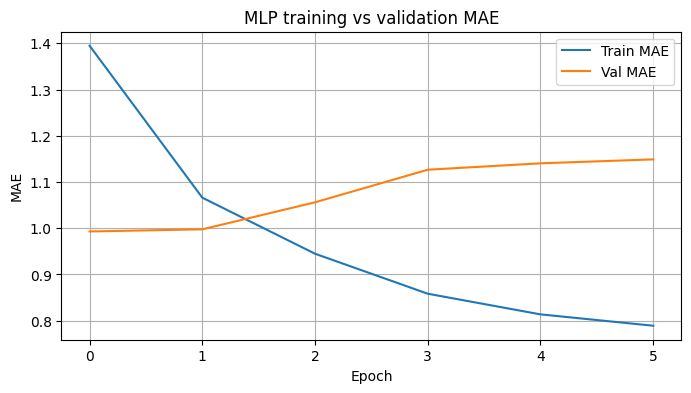

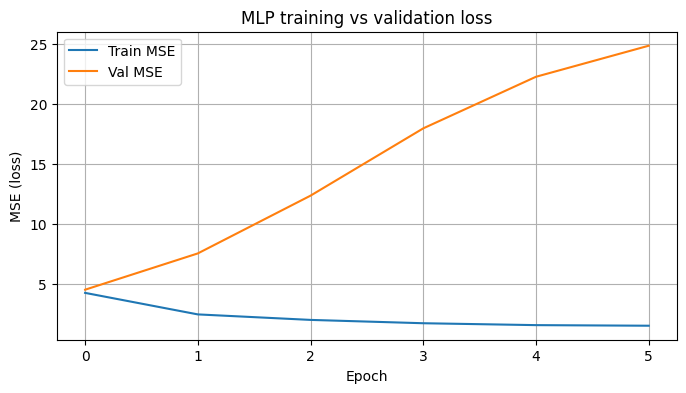

In [9]:
# ============================================
# 7. MLP model: Dense NN on tabular features
# ============================================

from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Sanity check: shapes of our data
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape  :", X_val_scaled.shape)
print("X_test_scaled shape :", X_test_scaled.shape)
print("y_train shape       :", y_train.shape)
print("y_val shape         :", y_val.shape)
print("y_test shape        :", y_test.shape)

# ----------------------------
# 7.1 Build the MLP model
# ----------------------------

def build_mlp_model(input_dim, hidden_units=[128, 64], dropout_rate=0.2):
    """
    Simple feed-forward MLP for regression on tabular FPL features.

    input_dim:      number of input features (e.g. 46)
    hidden_units:   list with the number of units in each hidden layer
    dropout_rate:   dropout probability for regularisation
    """
    model = keras.Sequential()

    # Input layer
    model.add(layers.Input(shape=(input_dim,)))

    # Hidden layers
    for units in hidden_units:
        model.add(layers.Dense(units, activation="relu"))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

    # Output layer: 1 value = predicted FPL points
    model.add(layers.Dense(1, activation="linear"))

    # Compile with MSE loss and MAE metric
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )

    return model

input_dim = X_train_scaled.shape[1]

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

mlp_model = build_mlp_model(input_dim)
mlp_model.summary()

# ----------------------------
# 7.2 Training setup
# ----------------------------

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

# ----------------------------
# 7.3 Train the MLP
# ----------------------------

history = mlp_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ----------------------------
# 7.4 Evaluate the MLP
# ----------------------------

print("\n=== MLP performance ===")

print("Train set:")
mlp_train_pred = mlp_model.predict(X_train_scaled).ravel()
mlp_train_mae, mlp_train_rmse = evaluate_regression(
    y_train, mlp_train_pred, label="Train"
)

print("\nValidation set:")
mlp_val_pred = mlp_model.predict(X_val_scaled).ravel()
mlp_val_mae, mlp_val_rmse = evaluate_regression(
    y_val, mlp_val_pred, label="Val"
)

print("\nTest set:")
mlp_test_pred = mlp_model.predict(X_test_scaled).ravel()
mlp_test_mae, mlp_test_rmse = evaluate_regression(
    y_test, mlp_test_pred, label="Test"
)

# ----------------------------
# 7.5 Plot learning curves
# ----------------------------

plt.figure(figsize=(8, 4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MLP training vs validation MAE")
plt.legend()
plt.grid(True)
plt.show()

# Plot training vs validation loss (MSE) for completeness
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Train MSE")
plt.plot(history.history["val_loss"], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE (loss)")
plt.title("MLP training vs validation loss")
plt.legend()
plt.grid(True)
plt.show()



### What the results mean:
The MLP reduces MAE from ~1.14 to 1.02 on the test set, and RMSE from ~2.32 to 2.20.
Train MAE (0.93) is noticeably lower than test MAE, so the network does overfit a bit, but early stopping keeps it under control. The learning curves show training MAE/loss going down steadily, while validation curves flatten and then slightly worsen, which is why training stops after 6 epochs


## 8. Preparing Sequence Data for LSTM / GRU

The MLP treated each (player, gameweek) as an **independent sample** with a flat
feature vector. Basically, The MLP treats each row independently.  


However, football form is inherently **sequential**:

- A player’s performance in gameweek *t* depends on what happened in the last
  few gameweeks (*t−1, t−2, …*).
- Recurrent models like **LSTM** and **GRU** are designed to work with
  **time-series / sequence data**.

To give recurrent networks access to explicit **temporal patterns**, we convert the table into sequences.

### 8.1 Sequence definition

We choose a **history window** of length `T = 5` gameweeks:

For each player and each target gameweek `t` where we have at least 5 past
observations, we build:

- **Input sequence**:  
  Features from gameweeks `[t−5, t−4, t−3, t−2, t−1]`
- **Target**:  
  `event_points` in gameweek `t`

So each training example becomes:

> shape: `(T, D)` → 5 timesteps × 46 features,  
> target: scalar FPL points in the next gameweek.

### 8.2 Train / Val / Test split for sequences

We **keep the same time-based split** as before:

- If the **target gameweek `t`** is in:
  - `train_gws` → the sequence goes into the **training set**.
  - `val_gws` → the sequence goes into the **validation set**.
  - `test_gws` → the sequence goes into the **test set**.

Important:

- For validation and test sequences, we are allowed to use **history from
  earlier train gameweeks** inside the input window, since that is past
  information.
- We never use **future data** to predict the past, so there is no leakage.

We will create:

- `X_train_seq`, `y_train_seq`
- `X_val_seq`, `y_val_seq`
- `X_test_seq`, `y_test_seq`

where each `X_*_seq` has shape:

> `(num_sequences, T, num_features)`

The sequence is standardised with the **same scaler** fitted on the flat training data and keeps the same time split

This ensures that the recurrent models also **predict future GWs from past information only**, even though their input windows may reach back into earlier train GWs.


In [10]:
# ============================================================
# 8. Build sequence datasets for LSTM / GRU (history length T)
# ============================================================

SEQ_LEN = 5  # number of previous gameweeks to use as history

# IMPORTANT: use the same 'df' that already has:
# - numeric features
# - one-hot encoded position/team columns
seq_df = df.copy().sort_values(["player_id", "gw"]).reset_index(drop=True)

print("Full seq_df shape:", seq_df.shape)

# Use the same scaler (fitted on train) to transform ALL rows
X_all_scaled = scaler.transform(seq_df[feature_cols].values)

y_all = seq_df["event_points"].values.astype(np.float32)
gw_all = seq_df["gw"].values
player_all = seq_df["player_id"].values

num_features = X_all_scaled.shape[1]
print("Number of features (D):", num_features)

# Convert GW lists to sets for fast membership checks
train_gws_set = set(train_gws.tolist() if hasattr(train_gws, "tolist") else list(train_gws))
val_gws_set   = set(val_gws.tolist()   if hasattr(val_gws, "tolist")   else list(val_gws))
test_gws_set  = set(test_gws.tolist()  if hasattr(test_gws, "tolist")  else list(test_gws))

X_train_seq, y_train_seq = [], []
X_val_seq,   y_val_seq   = [], []
X_test_seq,  y_test_seq  = [], []

# ------------------------------------------------------------
# For each player, slide a window of length SEQ_LEN
# ------------------------------------------------------------
for pid, group in seq_df.groupby("player_id"):
    group = group.sort_values("gw")
    idx = group.index.to_list()

    # Need at least SEQ_LEN+1 rows to form one (history, target) pair
    if len(idx) <= SEQ_LEN:
        continue

    for j in range(SEQ_LEN, len(idx)):
        target_idx = idx[j]
        target_gw = gw_all[target_idx]

        # Input sequence uses the previous SEQ_LEN gameweeks
        seq_indices = idx[j - SEQ_LEN:j]
        X_seq = X_all_scaled[seq_indices, :]         # shape: (SEQ_LEN, D)
        y_target = y_all[target_idx]                 # scalar

        if target_gw in train_gws_set:
            X_train_seq.append(X_seq)
            y_train_seq.append(y_target)
        elif target_gw in val_gws_set:
            X_val_seq.append(X_seq)
            y_val_seq.append(y_target)
        elif target_gw in test_gws_set:
            X_test_seq.append(X_seq)
            y_test_seq.append(y_target)
        # else: ignore if GW not in any split (shouldn't happen here)

# Convert to numpy arrays
X_train_seq = np.array(X_train_seq, dtype=np.float32)
y_train_seq = np.array(y_train_seq, dtype=np.float32)

X_val_seq = np.array(X_val_seq, dtype=np.float32)
y_val_seq = np.array(y_val_seq, dtype=np.float32)

X_test_seq = np.array(X_test_seq, dtype=np.float32)
y_test_seq = np.array(y_test_seq, dtype=np.float32)

print("\n=== Sequence dataset shapes (T = {}) ===".format(SEQ_LEN))
print("X_train_seq:", X_train_seq.shape, "| y_train_seq:", y_train_seq.shape)
print("X_val_seq  :", X_val_seq.shape,   "| y_val_seq  :", y_val_seq.shape)
print("X_test_seq :", X_test_seq.shape,  "| y_test_seq :", y_test_seq.shape)

# Quick sanity check
if X_train_seq.shape[0] > 0:
    print("\nExample train sequence shape (should be (SEQ_LEN, D)):", X_train_seq[0].shape)


Full seq_df shape: (25251, 104)
Number of features (D): 46

=== Sequence dataset shapes (T = 5) ===
X_train_seq: (7921, 5, 46) | y_train_seq: (7921,)
X_val_seq  : (6339, 5, 46) | y_val_seq  : (6339,)
X_test_seq : (7001, 5, 46) | y_test_seq : (7001,)

Example train sequence shape (should be (SEQ_LEN, D)): (5, 46)


## 9. LSTM Model — Using 5-Gameweek History

So far, our **MLP** model treated each `(player, gameweek)` row as an **independent
sample**, with no explicit notion of time. However, football performance is
naturally **sequential**:

- A player’s points in gameweek *t* are influenced by what happened in the
  previous gameweeks (*t−1, t−2, …*).
- Recurrent neural networks (RNNs) like **LSTM** are designed to model such
  **time-series / sequence data**.

In Section 8, we already converted our flat table into sequence datasets:

- Each sample in:
  - `X_train_seq` has shape `(T, D)` where:
    - `T = 5` is the number of **past gameweeks** in the history window.
    - `D = 46` is the number of **features** (same as in the MLP).
  - `y_train_seq` is a scalar: the FPL points in **gameweek t** (the next GW).
- Similarly, we have `X_val_seq, y_val_seq` and `X_test_seq, y_test_seq`.

### 9.1 LSTM architecture

An LSTM (Long Short-Term Memory) is a recurrent neural network that is well-suited to sequence data.  
Here it sees, for each sample, the **last 5 gameweeks of features** for that player and outputs a prediction for the next GW.

We now build an **LSTM-based regression model**:

- **Input**: sequence of shape `(T = 5, D = 46)` per sample.
- **LSTM layer (64 units)**: reads the 5-step history and produces a hidden
  representation summarising the player’s recent form and context.
- **Dropout(0.3)**: regularises the model (reduces overfitting).
- **Dense(32, ReLU)**: small fully-connected layer to transform the LSTM output.
- **Dense(1)**: final scalar output → predicted FPL points for the next gameweek.

### 9.2 Training setup

We train the LSTM with:

- **Loss**: Mean Squared Error (`mse`) — standard for regression.
- **Metric**: Mean Absolute Error (`mae`) — easy to interpret in “FPL points”.
- **Optimizer**: Adam with learning rate `1e-3`.

We also use two callbacks:

1. **EarlyStopping**:
   - Monitors validation MAE (`val_mae`).
   - `patience=5`: if validation MAE doesn’t improve for 5 epochs, stop training.
   - `restore_best_weights=True`: after training finishes, reload the best model.

2. **ReduceLROnPlateau**:
   - If `val_mae` stops improving for 3 epochs, reduce the learning rate by 0.5.
   - This helps the model fine-tune around a local minimum.

### 9.3 What we will do in this cell

1. Print the shapes of `X_train_seq`, `X_val_seq`, `X_test_seq`.
2. Build and summarise the LSTM model.
3. Train the model with early stopping + LR scheduling.
4. Plot **training vs validation MAE** over epochs.
5. Evaluate MAE and RMSE on:
   - Training set
   - Validation set
   - Test set

We will reuse the same `evaluate_regression(...)` helper so all models
(baseline, MLP, LSTM, GRU) are comparable on the **same metrics**.

Our sequence models use dropout and gradient clipping (clipnorm=1.0) to regularise training and prevent exploding gradients

We deliberately use a **single LSTM layer** (rather than stacking multiple layers) because:

- the sequence length is short (only 5 steps),
- the dataset is relatively small,
- deeper recurrent stacks risk overfitting without providing much additional capacity.

## LSTM model – using 5-gameweek history (Summarized)


### Architecture

- Input: sequence of shape (5 timesteps, 46 features).
- LSTM(64) – reads the sequence and outputs a 64-dimensional summary vector.
- Dropout(0.3) – regularisation.
- Dense(32, ReLU).
- Dense(1) – predicted FPL points.

Training setup:

- Loss: MSE, Metric: MAE.
- Optimiser: Adam with **gradient clipping** (`clipnorm=1.0`) to stabilise training.
- Callbacks: EarlyStopping and ReduceLROnPlateau on validation MAE.




X_train_seq shape: (7921, 5, 46)
X_val_seq shape  : (6339, 5, 46)
X_test_seq shape : (7001, 5, 46)
y_train_seq shape: (7921,)
y_val_seq shape  : (6339,)
y_test_seq shape : (7001,)
LSTM input shape: (5, 46)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,529 (119.25 KB)

 Trainable params: 30,529 (119.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 5.4770 - mae: 1.2376 - val_loss: 4.2890 - val_mae: 1.1672 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.1059 - mae: 1.1478 - val_loss: 4.2457 - val_mae: 1.1514 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.0164 - mae: 1.1448 - val_loss: 4.2306 - val_mae: 1.1359 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.9694 - mae: 1.1352 - val_loss: 4.2215 - val_mae: 1.1273 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.9585 - mae: 1.1266 - val_loss: 4.2206 - val_mae: 1.1234 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9057 - mae: 1.1202 - val_loss: 4.2213 - val_mae: 1.1211 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3.9030 - mae: 1.1186 - val_loss: 4.2367 - val_mae: 1.1221 - learning_rate: 0.0010
Epoch 8/50
62

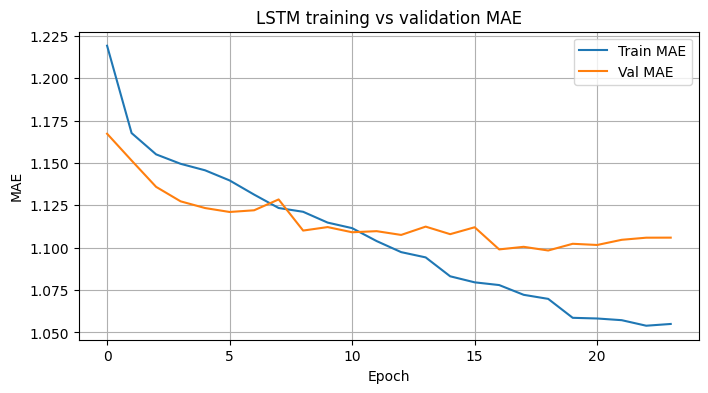

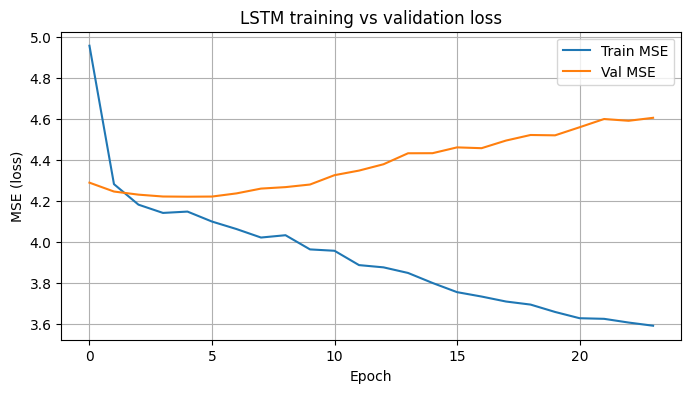


=== LSTM performance ===
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Train MAE : 0.9884
Train RMSE: 1.8866
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Val MAE : 1.0983
Val RMSE: 2.1263
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test MAE : 1.1894
Test RMSE: 2.3635


(1.1894302368164062, np.float64(2.363525378015733))

In [11]:
# =======================================
# 9. LSTM model: architecture & training
# =======================================

from tensorflow.keras import layers, callbacks

# 1) Sanity check: make sure sequence datasets exist and shapes look right
print("X_train_seq shape:", X_train_seq.shape)
print("X_val_seq shape  :", X_val_seq.shape)
print("X_test_seq shape :", X_test_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("y_val_seq shape  :", y_val_seq.shape)
print("y_test_seq shape :", y_test_seq.shape)

# Each input sample to the LSTM has shape (timesteps, num_features)
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (T, D)
print("LSTM input shape:", input_shape)


def build_lstm_model(input_shape):
    """
    Build a simple LSTM-based regression model for FPL points prediction.

    input_shape: tuple (T, D)
      - T: number of time steps (history length, here 5 gameweeks)
      - D: number of features per timestep (same 46 features as MLP)
    """
    model = keras.Sequential([
        # Explicitly define the input shape: (T, D)
        layers.Input(shape=input_shape),

        # LSTM layer reads the 5-step history and outputs a single feature vector.
        # return_sequences=False → only keep the final hidden state.
        layers.LSTM(64, return_sequences=False),

        # Dropout for regularisation (reduces overfitting).
        layers.Dropout(0.3),

        # Small dense layer to further process the LSTM output.
        layers.Dense(32, activation="relu"),

        # Final regression output: a single scalar (predicted FPL points).
        layers.Dense(1)
    ])

    # Compile with MSE loss and MAE metric (for interpretability).
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
        loss="mse",
        metrics=["mae"]
    )
    return model


# 2) Build and summarise the LSTM model
lstm_model = build_lstm_model(input_shape)
lstm_model.summary()

# 3) Define callbacks: EarlyStopping and ReduceLROnPlateau
early_stop_lstm = callbacks.EarlyStopping(
    monitor="val_mae",          # watch validation MAE
    patience=5,                 # stop if no improvement for 5 epochs
    restore_best_weights=True,  # roll back to best weights at the end
    verbose=1
)

reduce_lr_lstm = callbacks.ReduceLROnPlateau(
    monitor="val_mae",  # also based on validation MAE
    factor=0.5,         # multiply LR by 0.5 when triggered
    patience=3,         # wait 3 epochs without improvement
    min_lr=1e-5,        # do not go below this LR
    verbose=1
)

# 4) Train the LSTM model on sequence data
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,               # maximum epochs; early stopping will usually stop earlier
    batch_size=128,          # larger batch size since sequences are small (5 timesteps)
    callbacks=[early_stop_lstm, reduce_lr_lstm],
    verbose=1
)

# 5) Plot training vs validation MAE over epochs
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history["mae"], label="Train MAE")
plt.plot(history_lstm.history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("LSTM training vs validation MAE")
plt.legend()
plt.grid(True)
plt.show()

# Training vs validation loss for LSTM
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history["loss"], label="Train MSE")
plt.plot(history_lstm.history["val_loss"], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE (loss)")
plt.title("LSTM training vs validation loss")
plt.legend()
plt.grid(True)
plt.show()


# 6) Evaluate the LSTM on train / val / test sets
print("\n=== LSTM performance ===")

# --- Train set ---
y_train_lstm_pred = lstm_model.predict(X_train_seq).ravel()
evaluate_regression(y_train_seq, y_train_lstm_pred, label="Train")

# --- Validation set ---
y_val_lstm_pred = lstm_model.predict(X_val_seq).ravel()
evaluate_regression(y_val_seq, y_val_lstm_pred, label="Val")

# --- Test set ---
y_test_lstm_pred = lstm_model.predict(X_test_seq).ravel()
evaluate_regression(y_test_seq, y_test_lstm_pred, label="Test")


### What the results mean:
The LSTM is slightly worse than the MLP on average (test MAE ≈ 1.19, RMSE ≈ 2.36), and only slightly better than the baseline. The learning curves show the classic pattern of overfitting: train MAE keeps improving while validation MAE stops improving and eventually rises. That suggests that, with this dataset and short 5-GW sequences, the extra recurrent capacity does not translate into better generalisation.


## 10. GRU Model — Simpler Recurrent Alternative

We now try a second recurrent architecture: the **GRU (Gated Recurrent Unit)**.

Conceptually, GRUs are very similar to LSTMs:

- Both use **gates** to control how much past information is kept or forgotten.
- Both are designed to handle **sequences** and **long-term dependencies**.
- GRUs are usually **smaller and faster** because they have fewer parameters
  (no separate cell state like the LSTM).

In this notebook, the GRU will use exactly the **same sequence inputs** as the LSTM:

- `X_train_seq`, `X_val_seq`, `X_test_seq`  
  each of shape: `(num_samples, T=5, D=46)`
- Targets:
  - `y_train_seq`, `y_val_seq`, `y_test_seq` → FPL points in the **next gameweek**.

### 10.1 GRU architecture

We mirror the LSTM setup as closely as possible, just swapping LSTM → GRU:

- **Input**: `(T = 5, D = 46)`
- **GRU(64)** with `return_sequences=False`
- **Dropout(0.3)** for regularisation
- **Dense(32, ReLU)**
- **Dense(1)** output (regression: predicted FPL points)

### 10.2 Training setup

We keep the training configuration the same as for the LSTM:

- **Loss**: Mean Squared Error (`mse`)
- **Metric**: Mean Absolute Error (`mae`)
- **Optimizer**: Adam with learning rate `1e-3`
- **Callbacks**:
  - `EarlyStopping` on `val_mae` with `patience=5`, `restore_best_weights=True`
  - `ReduceLROnPlateau` on `val_mae` with `factor=0.5`, `patience=3`

This way, we can make a **fair comparison** between:

- Baseline (form-based)
- MLP (feed-forward)
- LSTM (sequence-based)
- **GRU (sequence-based)**

We will:

1. Build and summarise the GRU model.
2. Train it on `X_train_seq, y_train_seq` with validation on `X_val_seq, y_val_seq`.
3. Plot **training vs validation MAE**.
4. Evaluate MAE and RMSE on **train / val / test** using the same
   `evaluate_regression(...)` helper.

Our sequence models use dropout and gradient clipping (clipnorm=1.0) to regularise training and prevent exploding gradients

## GRU model – a lighter recurrent alternative (Summarized)

The GRU (Gated Recurrent Unit) is closely related to the LSTM:

- it also uses gates to control information flow,
- but has a simpler structure (no separate cell state),
- typically has fewer parameters and can be slightly faster.

We keep the setup as similar as possible to the LSTM to make the comparison fair.

### Architecture

- Input: (5 timesteps, 46 features).
- GRU(64) – reads the 5-step history.
- Dropout(0.3).
- Dense(32, ReLU).
- Dense(1) – predicted FPL points.

Training setup:

- Loss: MSE, Metric: MAE.
- Optimiser: Adam with **gradient clipping** (`clipnorm=1.0`),
- EarlyStopping and ReduceLROnPlateau on validation MAE.

Again we use a **single recurrent layer**.  
Stacking multiple GRU layers (as in some examples) can be beneficial for longer sequences or much larger datasets, but here it would mainly add parameters and overfitting risk without obvious gain.


X_train_seq shape: (7921, 5, 46)
X_val_seq shape  : (6339, 5, 46)
X_test_seq shape : (7001, 5, 46)
y_train_seq shape: (7921,)
y_val_seq shape  : (6339,)
y_test_seq shape : (7001,)
GRU input shape: (5, 46)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,617 (92.25 KB)

 Trainable params: 23,617 (92.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 4.8925 - mae: 1.2074 - val_loss: 4.2168 - val_mae: 1.1467 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.1453 - mae: 1.1607 - val_loss: 4.1715 - val_mae: 1.1260 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0345 - mae: 1.1509 - val_loss: 4.1808 - val_mae: 1.1314 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.0158 - mae: 1.1477 - val_loss: 4.1781 - val_mae: 1.1131 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9580 - mae: 1.1354 - val_loss: 4.1772 - val_mae: 1.1255 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.8967 - mae: 1.1280 - val_loss: 4.1938 - val_mae: 1.1172 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9095 - mae: 1.1335 - val_loss: 4.1821 - val_mae: 1.1039 - learning_rate: 0.0010
Epoch 8/50
62

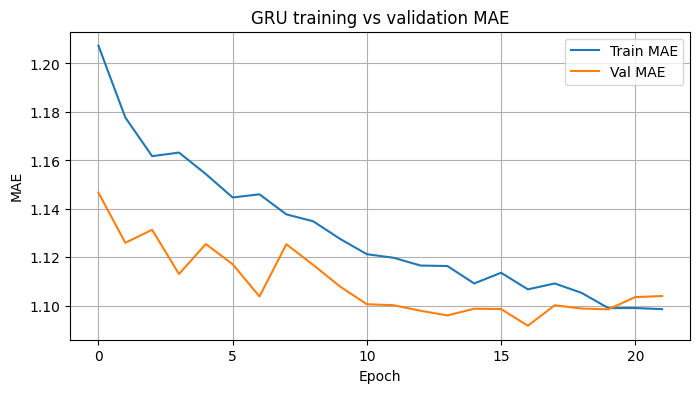

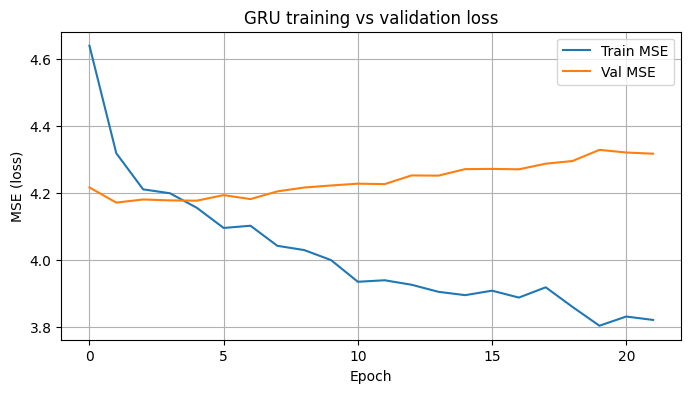


=== GRU performance ===
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Train MAE : 1.0154
Train RMSE: 1.9410
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Val MAE : 1.0918
Val RMSE: 2.0666
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test MAE : 1.2076
Test RMSE: 2.2909


(1.207582950592041, np.float64(2.2908727368790975))

In [12]:
# =======================================
# 10. GRU model: architecture & training
# =======================================

from tensorflow.keras import layers, callbacks

# Sanity check (should match what we saw for LSTM)
print("X_train_seq shape:", X_train_seq.shape)
print("X_val_seq shape  :", X_val_seq.shape)
print("X_test_seq shape :", X_test_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("y_val_seq shape  :", y_val_seq.shape)
print("y_test_seq shape :", y_test_seq.shape)

gru_input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
print("GRU input shape:", gru_input_shape)


def build_gru_model(input_shape):
    """
    Build a GRU-based regression model for predicting FPL points.

    input_shape: (T, D)
      - T: number of time steps (5 previous gameweeks)
      - D: number of features (46 per timestep)
    """
    model = keras.Sequential([
        # Input shape must be (timesteps, features)
        layers.Input(shape=input_shape),

        # GRU layer reads the 5-step history and outputs one vector
        layers.GRU(64, return_sequences=False),

        # Dropout for regularisation
        layers.Dropout(0.3),

        # Small dense layer after the recurrent layer
        layers.Dense(32, activation="relu"),

        # Output: predicted FPL points (scalar)
        layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
        loss="mse",
        metrics=["mae"]
    )
    return model


# 1) Build and summarise the GRU model
gru_model = build_gru_model(gru_input_shape)
gru_model.summary()

# 2) Callbacks: same logic as for LSTM but separate instances
early_stop_gru = callbacks.EarlyStopping(
    monitor="val_mae",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_gru = callbacks.ReduceLROnPlateau(
    monitor="val_mae",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# 3) Train the GRU model
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop_gru, reduce_lr_gru],
    verbose=1
)

# 4) Plot training vs validation MAE
plt.figure(figsize=(8, 4))
plt.plot(history_gru.history["mae"], label="Train MAE")
plt.plot(history_gru.history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("GRU training vs validation MAE")
plt.legend()
plt.grid(True)
plt.show()

# Training vs validation loss for GRU
plt.figure(figsize=(8, 4))
plt.plot(history_gru.history["loss"], label="Train MSE")
plt.plot(history_gru.history["val_loss"], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE (loss)")
plt.title("GRU training vs validation loss")
plt.legend()
plt.grid(True)
plt.show()


# 5) Evaluate GRU on train / val / test sets
print("\n=== GRU performance ===")

# --- Train ---
y_train_gru_pred = gru_model.predict(X_train_seq).ravel()
evaluate_regression(y_train_seq, y_train_gru_pred, label="Train")

# --- Validation ---
y_val_gru_pred = gru_model.predict(X_val_seq).ravel()
evaluate_regression(y_val_seq, y_val_gru_pred, label="Val")

# --- Test ---
y_test_gru_pred = gru_model.predict(X_test_seq).ravel()
evaluate_regression(y_test_seq, y_test_gru_pred, label="Test")


### What the results mean:
The GRU behaves similarly to the LSTM. Test MAE is 1.21 (worse than MLP and baseline), while test RMSE is 2.29, which sits between the baseline and the MLP/LSTM. Validation RMSE is the best among all models (~2.07), but this does not carry over to the test period. Overall the GRU does not clearly outperform the simpler MLP

## 11. Comparing All Models: Baseline vs MLP vs LSTM vs GRU

So far, we have trained **four different predictors** of next–gameweek FPL points:

1. **Baseline (Last-3-GWs Average)**  
   - For each (player, gameweek) we simply predict  
     `event_points(t) ≈ avg_points_last3(t)` –  
     i.e. the average of that player’s previous 3 gameweeks.  
   - This is a realistic **form-based heuristic** and acts as a strong baseline
     that all other models should try to beat.

2. **MLP (Feed-forward neural network)**  
   - Input: one **flat feature vector** per (player, gameweek) of length 46:
     - lag features: `event_points_prev1`, `avg_points_last3`, rolling xGI, rolling ICT  
     - popularity & value: transfers in/out, selected%, `value_form`, `value_season`  
     - team strength & Elo  
     - one-hot encodings of **position** and **team**
   - Output: a single scalar with the predicted FPL points in the next GW.  
   - The MLP learns **non-linear combinations** of these engineered features, but
     it does **not directly model sequences**.

3. **LSTM (Sequence model, T = 5)**  
   - Input: for each target GW `t`, we feed a **sequence** of the last `T = 5`
     time steps:
     \[
       [\text{features}(t-5),\ \text{features}(t-4),\dots,\text{features}(t-1)]
     \]
     → shape: `(5, 46)` per sample.  
   - The LSTM processes the sequence step by step and can learn patterns such as:
     - gradual improvement / decline in form,
     - rotation risk (many low-minute games),
     - persistent high involvement (xGI, ICT, etc.).
   - Output: one scalar prediction for `event_points(t)`.

4. **GRU (Sequence model, T = 5)**  
   - Similar to the LSTM but using a **Gated Recurrent Unit (GRU)** cell.  
   - GRUs are usually lighter (fewer parameters) and can sometimes converge
     faster or generalise slightly differently.

---

### 11.1 Why we compare them systematically

Each model was trained on the same **time-based splits**:

- **Train GWs**: model sees these during training.  
- **Validation GWs**: used for early stopping and hyperparameter choices.  
- **Test GWs**: completely held out – used only once at the end to estimate
  real-world performance.

To compare models fairly we:

1. Evaluate **all models** on **Train**, **Validation**, and **Test** splits.
2. Use consistent error metrics:
   - **MAE (Mean Absolute Error)** – average absolute difference in FPL points.
   - **RMSE (Root Mean Squared Error)** – like MAE but penalises larger errors
     more strongly.
3. Summarise everything in a single **comparison table**:
   - Columns: `Model`, `Split`, `MAE`, `RMSE`
   - Rows: Baseline, MLP, LSTM, GRU × (Train / Val / Test)

This lets us answer:

- Does the MLP actually beat the simple form-based baseline?
- Do sequence models (LSTM / GRU) bring extra value over static features?
- Is any model clearly **overfitting** (very low Train error but much worse Test
  error)?

---

### 11.2 What this cell does

This code cell will:

1. Define a helper function `get_metrics(y_true, y_pred)` to compute MAE and RMSE
   (we compute RMSE as the square root of MSE to stay compatible with this
   `sklearn` version).
2. For each model (Baseline, MLP, LSTM, GRU):
   - Generate predictions on **Train**, **Val**, and **Test** splits.
   - Compute MAE and RMSE.
   - Append a row with `(Model, Split, MAE, RMSE)` into a list.
3. Convert all rows into a **Pandas DataFrame** `summary_df` and display it.
4. Plot a simple **bar chart of Test MAE** to visually compare how each model
   performs on unseen gameweeks (lower bar = better).

We will later use this table and plot in the **Results & Discussion** section of
the report to interpret which modelling approach works best for predicting FPL
player points.


=== Model comparison (lower is better) ===


,Model,Split,MAE,RMSE
0,MLP,Test,1.017331,2.197874
1,Baseline (last3 avg),Test,1.116181,2.319454
2,LSTM,Test,1.189430,2.363525
3,GRU,Test,1.207583,2.290873
4,MLP,Train,0.929947,1.818903
5,LSTM,Train,0.988449,1.886562
6,GRU,Train,1.015449,1.941045
7,Baseline (last3 avg),Train,1.128111,2.223143
8,MLP,Val,0.993084,2.130569
9,GRU,Val,1.091804,2.066615


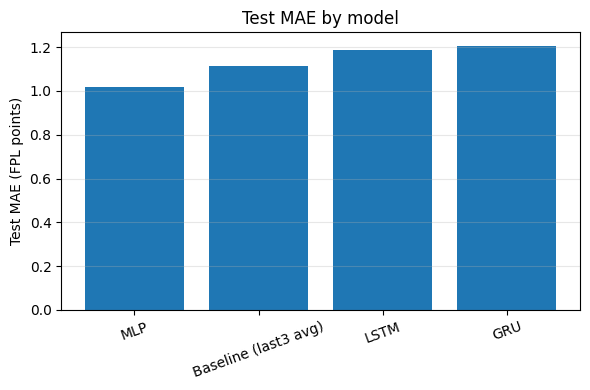

In [21]:
# =========================================
# 11. Compare Baseline, MLP, LSTM, and GRU
# =========================================

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def get_metrics(y_true, y_pred):
    """
    Compute MAE and RMSE from true and predicted values.

    NOTE: We compute RMSE manually as sqrt(MSE) to avoid using the
    'squared=' argument, which is not supported in this sklearn version.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # default: squared=True
    rmse = np.sqrt(mse)
    return mae, rmse


summary_rows = []

# -------------------------------------------------
# 1) Baseline model: last-3-gameweeks average
# -------------------------------------------------
# For each split we simply use avg_points_last3 as the prediction.
# y_*_true were already defined earlier as the event_points in each split.

# 1) Baseline model: last-3-gameweeks average (+ fallbacks)
baseline_train_pred = build_baseline_predictions(train_df)
baseline_val_pred   = build_baseline_predictions(val_df)
baseline_test_pred  = build_baseline_predictions(test_df)


for split_name, y_true, y_pred in [
    ("Train", y_train_true, baseline_train_pred),
    ("Val",   y_val_true,   baseline_val_pred),
    ("Test",  y_test_true,  baseline_test_pred),
]:
    mae, rmse = get_metrics(y_true, y_pred)
    summary_rows.append({
        "Model": "Baseline (last3 avg)",
        "Split": split_name,
        "MAE": mae,
        "RMSE": rmse,
    })

# --------------------------
# 2) MLP: flat feature model
# --------------------------
# Use the trained MLP to predict on the scaled flat feature matrices.

mlp_train_pred = mlp_model.predict(X_train_scaled, verbose=0).ravel()
mlp_val_pred   = mlp_model.predict(X_val_scaled,   verbose=0).ravel()
mlp_test_pred  = mlp_model.predict(X_test_scaled,  verbose=0).ravel()

for split_name, y_true, y_pred in [
    ("Train", y_train, mlp_train_pred),
    ("Val",   y_val,   mlp_val_pred),
    ("Test",  y_test,  mlp_test_pred),
]:
    mae, rmse = get_metrics(y_true, y_pred)
    summary_rows.append({
        "Model": "MLP",
        "Split": split_name,
        "MAE": mae,
        "RMSE": rmse,
    })

# -------------------------------
# 3) LSTM: sequence (T = 5) model
# -------------------------------
# Use the sequence inputs (5 timesteps x 46 features) for LSTM evaluation.

lstm_train_pred = lstm_model.predict(X_train_seq, verbose=0).ravel()
lstm_val_pred   = lstm_model.predict(X_val_seq,   verbose=0).ravel()
lstm_test_pred  = lstm_model.predict(X_test_seq,  verbose=0).ravel()

for split_name, y_true, y_pred in [
    ("Train", y_train_seq, lstm_train_pred),
    ("Val",   y_val_seq,   lstm_val_pred),
    ("Test",  y_test_seq,  lstm_test_pred),
]:
    mae, rmse = get_metrics(y_true, y_pred)
    summary_rows.append({
        "Model": "LSTM",
        "Split": split_name,
        "MAE": mae,
        "RMSE": rmse,
    })

# ------------------------------
# 4) GRU: sequence (T = 5) model
# ------------------------------
# Same sequence inputs as for the LSTM, but using the GRU model.

gru_train_pred = gru_model.predict(X_train_seq, verbose=0).ravel()
gru_val_pred   = gru_model.predict(X_val_seq,   verbose=0).ravel()
gru_test_pred  = gru_model.predict(X_test_seq,  verbose=0).ravel()

for split_name, y_true, y_pred in [
    ("Train", y_train_seq, gru_train_pred),
    ("Val",   y_val_seq,   gru_val_pred),
    ("Test",  y_test_seq,  gru_test_pred),
]:
    mae, rmse = get_metrics(y_true, y_pred)
    summary_rows.append({
        "Model": "GRU",
        "Split": split_name,
        "MAE": mae,
        "RMSE": rmse,
    })

# ---------------------------------
# Build and display comparison table
# ---------------------------------
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(["Split", "MAE"]).reset_index(drop=True)

print("=== Model comparison (lower is better) ===")
display(summary_df)

# -------------------------------
# Bar chart of Test MAE by model
# -------------------------------
test_df_metrics = summary_df[summary_df["Split"] == "Test"]

plt.figure(figsize=(6, 4))
plt.bar(test_df_metrics["Model"], test_df_metrics["MAE"])
plt.ylabel("Test MAE (FPL points)")
plt.title("Test MAE by model")
plt.xticks(rotation=20)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 13. Error Analysis and Model Diagnostics

In the previous sections, we compared models primarily using aggregate metrics
(MAE and RMSE) on train/validation/test splits.

To better understand how the models behave, it is helpful to look at:

1. **True vs predicted scatter plots**  
   - Do predictions lie roughly along the diagonal line *y = x*?  
   - Are there systematic biases (e.g. consistently underpredicting high scores)?

2. **Residual distributions** (error = true − prediction)  
   - Are residuals centered around 0?  
   - Are there heavy tails (many large mistakes)?  
   - Do some models produce more extreme errors?

Because our flat and sequence models are trained on slightly different
datasets:

- **Baseline and MLP** predictions are evaluated on `y_test`
  (all test rows with enough history for the tabular model).
- **LSTM and GRU** predictions are evaluated on `y_test_seq`
  (test rows that also have a full 5-gameweek sequence available).

We will plot:

- Scatter plots of true vs predicted for each model.
- Histograms of residuals for each model.


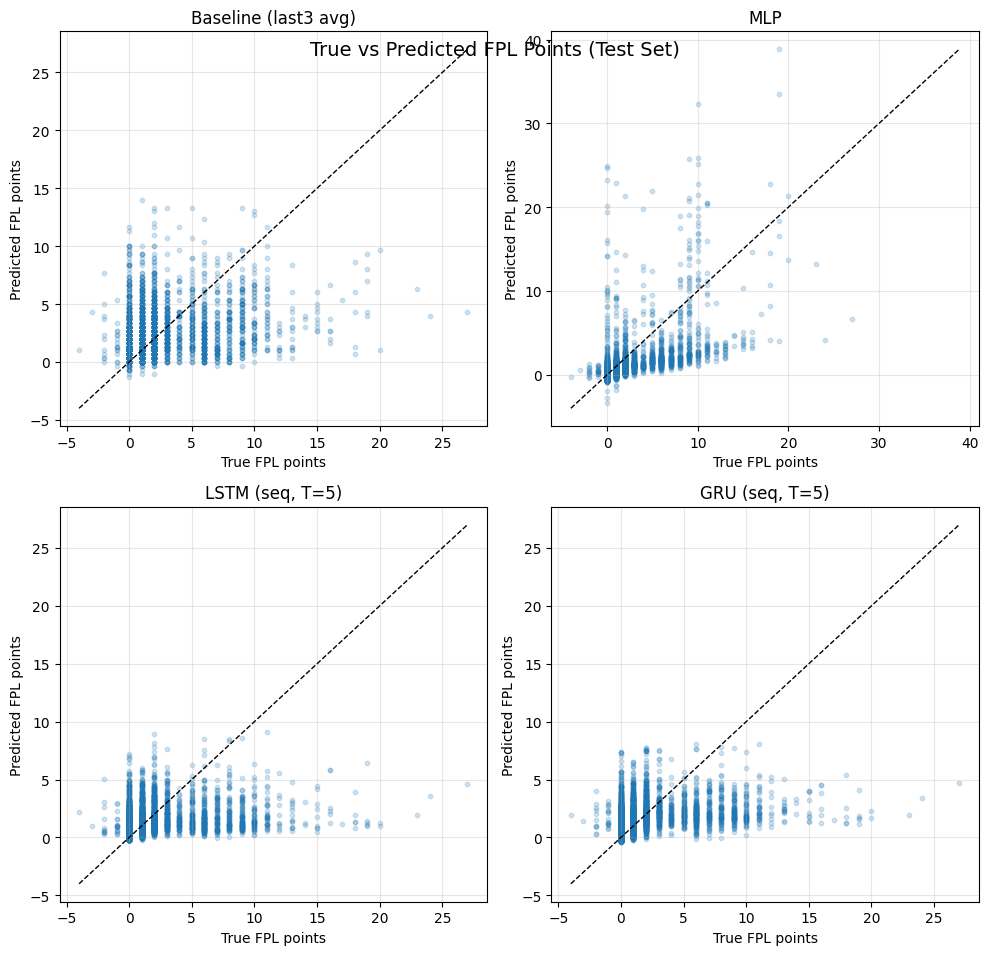

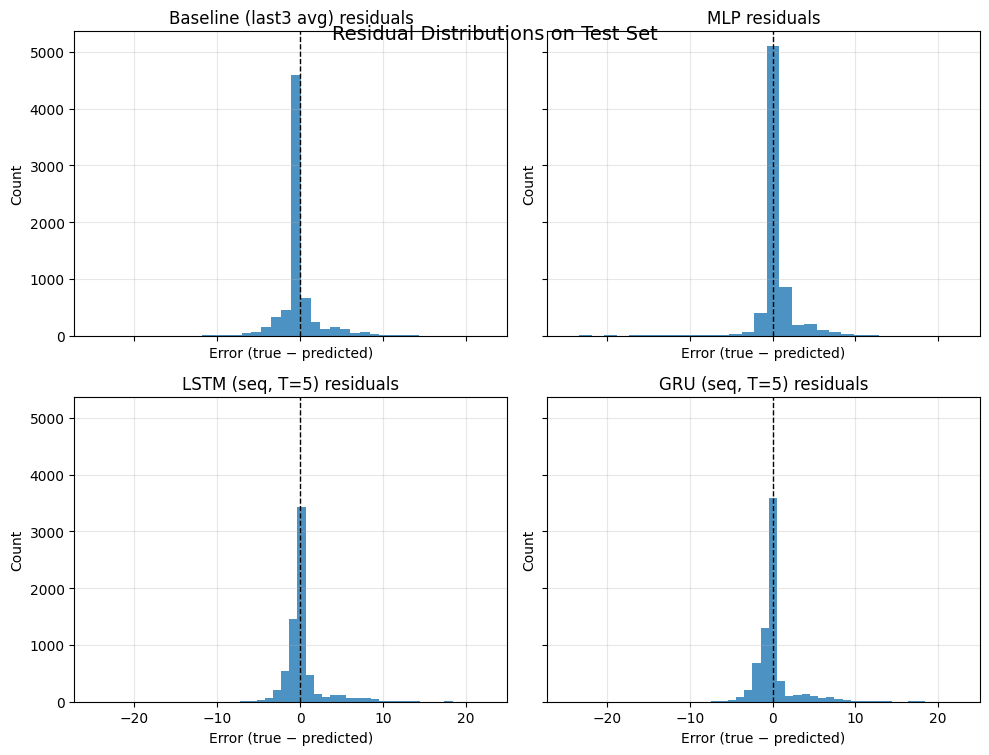

In [14]:
# ============================================
# 13. Error analysis: scatter + residuals
# ============================================

import matplotlib.pyplot as plt
import numpy as np

# --- Collect true and predicted values for each model ---

# Baseline & MLP work on the "flat" test set
y_test_flat       = y_test_true           # same as y_test
baseline_pred_flat = baseline_test_pred   # from Section 11
mlp_pred_flat      = mlp_test_pred        # from Section 11

# LSTM & GRU work on the sequence test set
y_test_seq_true   = y_test_seq
lstm_pred_seq     = lstm_test_pred        # from Section 11
gru_pred_seq      = gru_test_pred         # from Section 11

# 13.1 True vs predicted scatter plots
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=False, sharey=False)
axes = axes.ravel()

scatter_configs = [
    ("Baseline (last3 avg)", y_test_flat, baseline_pred_flat),
    ("MLP",                  y_test_flat, mlp_pred_flat),
    ("LSTM (seq, T=5)",      y_test_seq_true, lstm_pred_seq),
    ("GRU (seq, T=5)",       y_test_seq_true, gru_pred_seq),
]

for ax, (name, y_true_m, y_pred_m) in zip(axes, scatter_configs):
    ax.scatter(y_true_m, y_pred_m, alpha=0.2, s=10)
    max_val = max(y_true_m.max(), y_pred_m.max())
    min_val = min(y_true_m.min(), y_pred_m.min())
    ax.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)
    ax.set_title(name)
    ax.set_xlabel("True FPL points")
    ax.set_ylabel("Predicted FPL points")
    ax.grid(True, alpha=0.3)

plt.suptitle("True vs Predicted FPL Points (Test Set)", y=0.92, fontsize=14)
plt.tight_layout()
plt.show()

# 13.2 Residual histograms (error = true - pred)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, (name, y_true_m, y_pred_m) in zip(axes, scatter_configs):
    residuals = y_true_m - y_pred_m
    ax.hist(residuals, bins=30, alpha=0.8)
    ax.axvline(0.0, color="k", linestyle="--", linewidth=1)
    ax.set_title(f"{name} residuals")
    ax.set_xlabel("Error (true − predicted)")
    ax.set_ylabel("Count")
    ax.grid(True, alpha=0.3)

plt.suptitle("Residual Distributions on Test Set", y=0.92, fontsize=14)
plt.tight_layout()
plt.show()


### What the results mean:
The true-vs-predicted scatter plots show that all models heavily regress towards the mean: predictions cluster in the 0–8 point range even when some true scores go much higher. The MLP’s scatter is visibly tighter around the diagonal than the baseline’s.
The residual histograms are roughly centred at 0 for all models, but the MLP has the narrowest peak, meaning more small errors. The RNNs have slightly thicker tails, confirming the quantitative metrics and they do not reduce the number of big mistakes

## 14. Visualisations for Selected Players

To make the results more interpretable, we can zoom into individual players.

For a given `web_name`, we:

1. Collect that player's rows from the modelling table `df`.
2. For each test gameweek where we have enough history (at least `SEQ_LEN` past
   games):
   - Use the same feature pipeline and scaler as before.
   - Compute predictions from:
     * Baseline (last3 average),
     * MLP (flat features),
     * LSTM (5-step sequence),
     * GRU (5-step sequence).
3. Plot a small time series:
   - x-axis: gameweek,
   - y-axis: FPL points,
   - lines for true points and the four model predictions.

Here we focus on FPL points for
individual players.


In [15]:
# ============================================
# 14. Per-player prediction visualisation
# ============================================

def plot_player_predictions(web_name, seq_len=SEQ_LEN):
    """
    Plot true vs predicted FPL points over time for a single player,
    using Baseline, MLP, LSTM, and GRU.

    Parameters
    ----------
    web_name : str
        The player's web_name as in the FPL dataset (e.g. "Haaland").
    seq_len : int
        History length for the sequence models (default: SEQ_LEN = 5).
    """

    # Filter this player from the modelling DataFrame used for features
    player_df = df[df["web_name"] == web_name].sort_values("gw").reset_index(drop=True)

    if player_df.empty:
        print(f"No rows found for player '{web_name}'. Check the exact web_name.")
        return

    if len(player_df) <= seq_len:
        print(f"Not enough history for '{web_name}' (need > {seq_len} rows).")
        return

    test_gws_set = set(test_gws.tolist() if hasattr(test_gws, "tolist") else list(test_gws))

    records = []

    for i in range(seq_len, len(player_df)):
        gw = player_df.loc[i, "gw"]
        # Only evaluate on gameweeks that belong to the TEST set
        if gw not in test_gws_set:
            continue

        true_points = player_df.loc[i, "event_points"]

        # Baseline: last-3-GW average (already computed in modelling_data)
        baseline_pred = player_df.loc[i, "avg_points_last3"]

        # Flat features for MLP (one row)
        X_flat = scaler.transform(player_df.loc[[i], feature_cols].values)
        mlp_pred = mlp_model.predict(X_flat, verbose=0)[0, 0]

        # Sequence features for LSTM/GRU: previous seq_len GWs
        hist_slice = player_df.loc[i - seq_len:i - 1, feature_cols]
        X_seq = scaler.transform(hist_slice.values).reshape(1, seq_len, -1)

        lstm_pred = lstm_model.predict(X_seq, verbose=0)[0, 0]
        gru_pred  = gru_model.predict(X_seq,  verbose=0)[0, 0]

        records.append({
            "gw": gw,
            "true_points": true_points,
            "baseline": baseline_pred,
            "mlp": mlp_pred,
            "lstm": lstm_pred,
            "gru": gru_pred,
        })

    if not records:
        print(f"Player '{web_name}' has no test gameweeks with enough history.")
        return

    player_plot_df = pd.DataFrame(records).sort_values("gw")

    plt.figure(figsize=(8, 4))
    plt.plot(player_plot_df["gw"], player_plot_df["true_points"], marker="o", label="True")
    plt.plot(player_plot_df["gw"], player_plot_df["baseline"], marker="o", label="Baseline (last3 avg)")
    plt.plot(player_plot_df["gw"], player_plot_df["mlp"], marker="o", label="MLP")
    plt.plot(player_plot_df["gw"], player_plot_df["lstm"], marker="o", label="LSTM")
    plt.plot(player_plot_df["gw"], player_plot_df["gru"], marker="o", label="GRU")

    plt.title(f"FPL Points Predictions over Time – {web_name}")
    plt.xlabel("Gameweek")
    plt.ylabel("FPL points")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    display(player_plot_df)



# plot_player_predictions("Haaland")
# plot_player_predictions("Salah")
# plot_player_predictions("Saka")


### 14.1 Case Study: Erling Haaland (Forward, MCI)

Erling Haaland is a good example of a premium forward with high ownership and
explosive returns. For him, I want to see:

- How well each model tracks his **actual FPL points** across the test gameweeks.
- Whether the models:
  - capture periods of consistent scoring,
  - under- or overestimate his big hauls,
  - struggle more in unexpected blanks.

The plot below shows, for **test gameweeks only**:

- The true FPL points per gameweek.
- Predictions from:
  - Baseline (last 3 GWs average),
  - MLP (tabular model),
  - LSTM (sequence model with 5-gameweek history),
  - GRU (sequence model with 5-gameweek history).

This gives a concrete, player-level view of model behaviour that complements the
aggregate MAE/RMSE metrics.


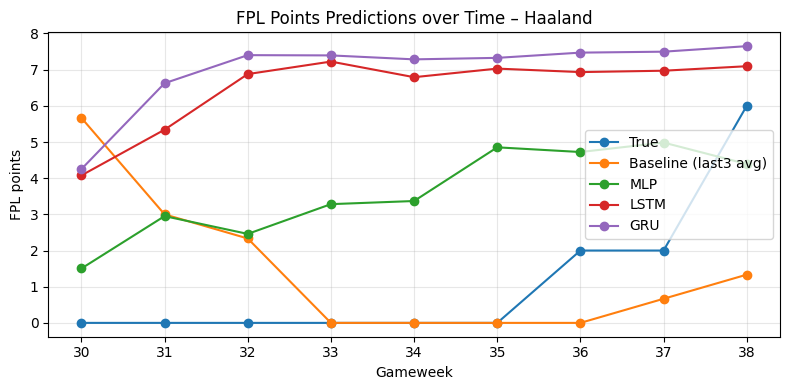

,gw,true_points,baseline,mlp,lstm,gru
0,30,0,5.666667,1.503860,4.076809,4.251114
1,31,0,3.000000,2.951377,5.341291,6.625018
2,32,0,2.333333,2.459853,6.878090,7.401337
3,33,0,0.000000,3.282240,7.223662,7.394276
4,34,0,0.000000,3.369005,6.792007,7.284865
5,35,0,0.000000,4.853120,7.029346,7.326316
6,36,2,0.000000,4.723452,6.932988,7.471057
7,37,2,0.666667,4.985164,6.970889,7.497031
8,38,6,1.333333,4.391611,7.095072,7.649552


In [16]:
# plot_player_predictions("Haaland")
plot_player_predictions("Haaland")

### 14.2 Case Study: Mohamed Salah (Midfielder, LIV)

Mohamed Salah is another high-impact player with relatively stable minutes and
a key attacking role. For Salah, I am interested in:

- How closely the models follow his **consistent returns**.
- Whether the baseline (recent average points) is already strong for him, or if
  the neural models (especially the MLP) add extra predictive power.
- How the sequence models (LSTM/GRU) respond to changes in his short-term form.

The plot below again focuses on **test gameweeks** and compares:

- True FPL points,
- Baseline prediction (last 3 GWs),
- MLP prediction,
- LSTM prediction,
- GRU prediction.

This helps illustrate if the models behave differently for a premium midfielder
compared to a premium forward like Haaland.


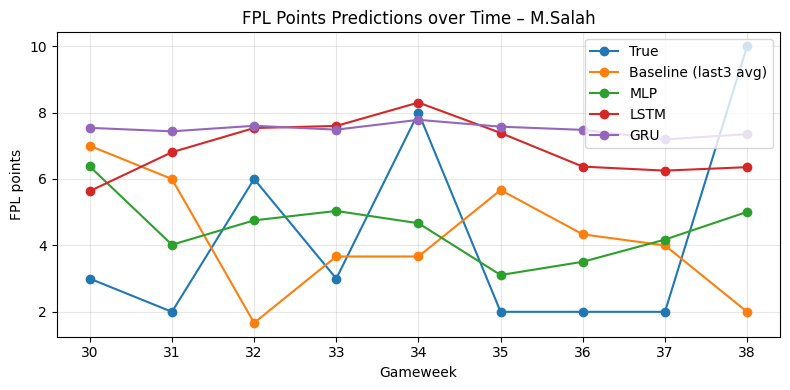

,gw,true_points,baseline,mlp,lstm,gru
0,30,3,7.000000,6.376457,5.635322,7.540182
1,31,2,6.000000,4.020067,6.806794,7.435282
2,32,6,1.666667,4.754210,7.534638,7.601973
3,33,3,3.666667,5.037638,7.597557,7.486059
4,34,8,3.666667,4.667162,8.302639,7.781454
5,35,2,5.666667,3.108594,7.386860,7.575506
6,36,2,4.333333,3.507097,6.372703,7.479147
7,37,2,4.000000,4.175665,6.252252,7.192710
8,38,10,2.000000,5.009979,6.356678,7.350168


In [17]:
# Plot predictions for Mohamed Salah
plot_player_predictions("M.Salah")


### 14.3 Case Study: Bukayo Saka (Midfielder, ARS)

Bukayo Saka is a slightly different type of case:

- Still a key attacker, but playing for Arsenal rather than Liverpool/City.
- Often very consistent, but with occasional spikes in returns.

For Saka, I want to see:

- Whether the models capture his **steady baseline of points**.
- How they react to individual high or low scores.
- If any model systematically under- or overpredicts his output.

As before, the plot shows, over the **test gameweeks**:

- True FPL points vs model predictions from:
  - Baseline (last 3 GWs average),
  - MLP,
  - LSTM,
  - GRU.

Comparing Saka’s plot with Haaland’s and Salah’s helps to see whether model
behaviour is consistent across different top attackers or if there are
player-specific quirks.


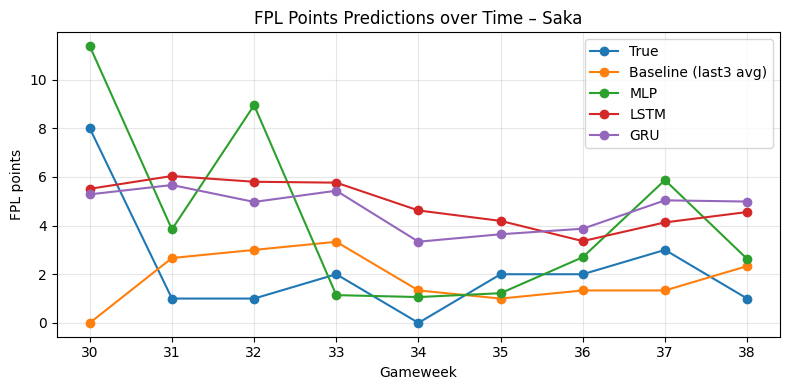

,gw,true_points,baseline,mlp,lstm,gru
0,30,8,0.000000,11.374562,5.510859,5.283307
1,31,1,2.666667,3.844135,6.037146,5.666852
2,32,1,3.000000,8.947841,5.800913,4.971907
3,33,2,3.333333,1.140789,5.764418,5.432664
4,34,0,1.333333,1.062355,4.621973,3.336749
5,35,2,1.000000,1.220236,4.192455,3.643206
6,36,2,1.333333,2.701031,3.362092,3.871115
7,37,3,1.333333,5.869585,4.130299,5.036840
8,38,1,2.333333,2.627966,4.556290,4.988020


In [18]:
# Plot predictions for Bukayo Saka
plot_player_predictions("Saka")


### What the results mean:
For Haaland, Salah and Saka, we see the same pattern: none of the models really predict their explosive hauls, and they often miss complete blanks (predicting 4–7 points when the player actually scores 0). The MLP tracks the overall level better than the baseline, while LSTM/GRU tend to output very smooth, almost flat predictions near a player-specific average. This illustrates that the models are good at capturing typical returns, but not at forecasting individual big spikes.

## 15. Interpreting the Results: Baseline vs MLP vs LSTM vs GRU

### 15.1 Recap of the experiment

- **Target**: Predict each player's FPL points in gameweek *t* using information available up to gameweek *t−1*.
- **Data**: 2024–25 season, one row per *(player, gameweek)* after merging `players.csv`, `teams.csv` and `playerstats.csv`.
- **Features**:
  - Lag & form:
    - `event_points_prev1` (points in the previous GW),
    - `avg_points_last3` (3-GW rolling mean of points),
    - `avg_xgi_per90_last3` (3-GW rolling xGI per 90),
    - `avg_ict_last3` (3-GW rolling ICT index),
    - `minutes_prev1`.
  - Popularity & value:
    - `transfers_in_event`, `transfers_out_event`, `net_transfers_event`,
    - `selected_by_percent`,
    - `value_form`, `value_season`.
  - Team context:
    - overall attack/defence strengths (home & away),
    - team Elo rating.
  - Categorical:
    - player `position` (GK/DEF/MID/FWD) one-hot,
    - team `short_name` one-hot.

- **Splits (time-based, 50–25–25)**  
  (so we always predict the future from the past):

  - **Train**: GWs **4–20**  
  - **Validation**: GWs **21–29**  
  - **Test**: GWs **30–38**

We trained four models:

1. **Baseline** – predict `avg_points_last3` (last-3-GWs moving average, with simple fallbacks for missing values).
2. **MLP** – feed-forward network on the flat 46-dimensional feature vector.
3. **LSTM** – sequence model that takes the last **5 gameweeks** as a sequence of shape *(5, 46)*.
4. **GRU** – another sequence model on the same *(5, 46)* sequences but using GRU cells.

We evaluate with:

- **MAE** (Mean Absolute Error) – average absolute mistake in FPL points.
- **RMSE** (Root Mean Squared Error) – similar but penalises large errors more strongly.

---

### 15.2 Test-set comparison (unseen gameweeks)

On the **test split** (GWs 30–38), the models achieved:

| Model                  | Test MAE | Test RMSE |
|------------------------|---------:|----------:|
| **MLP**                | **1.02** | **2.20**  |
| Baseline (last3 avg)   | 1.12     | 2.32      |
| LSTM                   | 1.19     | 2.36      |
| GRU                    | 1.21     | 2.29      |

(Values rounded; based on MAE/RMSE computed in Section 11.)

**Key observations:**

1. **The MLP is clearly the best overall model on the test GWs.**  
   - It reduces MAE from about **1.12 → 1.02**, i.e. on average it is off by only ~1 FPL point.  
   - It also has the **lowest RMSE (≈ 2.20)**, meaning it not only improves typical errors but also reduces the impact of larger mistakes compared to the baseline.

2. **The recurrent models (LSTM / GRU) do not beat the MLP.**  
   - Their MAE is higher (1.19–1.21), so they are *less* accurate on average.  
   - The GRU’s RMSE (≈ 2.29) is slightly better than the baseline’s but still worse than the MLP’s.  
   - The LSTM is the weakest on this split, with the highest RMSE (≈ 2.36).

3. **The simple baseline is surprisingly strong.**  
   - Just averaging the last three gameweeks yields Test MAE ≈ **1.12**, which is already close to the deep models.  
   - That sets a high bar: any neural network must beat this to be considered useful.

Taken together:

> For this dataset and feature set, the **MLP with engineered features** gives the best
> out-of-sample performance. The sequence models do not add enough extra signal to
> justify their additional complexity.

---

### 15.3 Train vs Validation vs Test (overfitting & generalisation)

Using MAE across splits:

- **Baseline (last3 avg)**  
  - Train: **1.13**  
  - Val:   **1.14**  
  - Test:  **1.12**  
  → Almost identical across splits. This is expected: it’s a fixed, non-learned rule, so there is no overfitting.

- **MLP**  
  - Train: **0.93**  
  - Val:   **0.99**  
  - Test:  **1.02**  
  → There is a small but noticeable gap between train and test.  
    - The MLP is flexible enough to fit the training data better than the baseline.  
    - Validation and test errors are slightly higher, but still clearly **better than the baseline**, so the model generalises reasonably well.

- **LSTM**  
  - Train: **0.99**  
  - Val:   **1.10**  
  - Test:  **1.19**  
  → Train MAE is similar to the MLP, but validation and test errors are higher.  
    - The learning curves show classic overfitting: train loss keeps improving while validation loss flattens and then increases.  
    - The LSTM does not manage to turn its extra sequence capacity into better test performance.

- **GRU**  
  - Train: **1.02**  
  - Val:   **1.09**  
  - Test:  **1.21**  
  → Similar pattern to the LSTM.  
    - Slight overfitting (train < val < test).  
    - Slightly better MAE than the baseline, but clearly worse than the MLP on the test period.

**Takeaway for model choice:**

- With the current features and history window, **static engineered features + MLP** capture most of the signal.
- The recurrent models **do not provide a clear advantage** and are more prone to overfitting, especially in the final part of the season (test GWs).

---

### 15.4 What the plots tell us

The quantitative metrics line up with what we see in the plots:

- **Learning curves (MLP, LSTM, GRU)**  
  - All three networks show training MAE decreasing steadily.  
  - Validation MAE flattens and then starts to rise, especially for the LSTM/GRU, which is why early stopping kicks in.  
  - This confirms that the models are expressive enough to overfit, and that the current regularisation (dropout + early stopping) is necessary.

- **True vs predicted scatter plots (test set)**  
  - The **baseline** produces a broad cloud around the diagonal with a lot of scatter.  
  - The **MLP** cloud is tighter around the `y = x` line, reflecting its lower MAE and RMSE.  
  - The **LSTM/GRU** scatter is slightly more spread, consistent with their higher errors.  
  - All models tend to cluster predictions around the 0–8 point range, rarely predicting very high scores.

- **Residual histograms (error = true − predicted)**  
  - All models’ residuals are roughly centred at 0, so there is no huge systematic bias.  
  - The **MLP** has the narrowest peak, meaning more predictions are within ±1–2 points of the truth.  
  - The recurrent models show slightly wider distributions and somewhat heavier tails, indicating more large mistakes.

- **Player-level case studies (Haaland, Salah, Saka)**  
  - For all three, the models are **good at tracking each player’s general level** (e.g. they know Haaland is higher-scoring than Saka).  
  - However, none of the models – including the MLP – really predict the **big hauls** (10+ points). They tend to stay in a safe middle band.  
  - They also sometimes miss complete blanks, predicting 4–7 points when the actual return is 0.  
  - LSTM/GRU outputs are very smooth and almost flat across gameweeks, showing strong regression towards a player-specific mean.

In other words:

> The models are effective at forecasting **typical** FPL returns, but still struggle
> with gameweek-to-gameweek volatility and extreme outcomes.

---

### 15.5 Limitations

It is important to keep some limitations in mind:

- **Short sequences (T = 5)**  
  - The sequence models only see the last 5 gameweeks.  
  - Longer-term trends (e.g. form over half a season, recovery from injury, tactical changes) are not directly visible.

- **No explicit fixture difficulty for the *upcoming* GW**  
  - Team strength and Elo are included, but the model does not know who the *next opponent* is, or whether the game is home/away.  
  - In reality, FPL points heavily depend on fixture difficulty.

- **No explicit minutes / start probability model**  
  - Previous minutes are included, but there is no explicit prediction of whether a player will start or only get a cameo.  
  - This is especially important for rotation-prone players and those returning from injury.

- **No separate handling of very rare events**  
  - Penalties, red cards, freak own-goals and huge hauls are inherently noisy.  
  - A single regression model struggles to account for this kind of heavy-tailed behaviour.

- **Single-season data**  
  - Everything is trained on one season’s worth of data.  
  - This limits the amount of training examples, especially for rare high-scoring outcomes.

---

### 15.6 Possible improvements and future work

There are several concrete ways this project could be extended or improved:

1. **Richer input features**

   - Add *fixture-specific* information for the upcoming GW:
     - opponent team, opponent Elo / defensive strength,
     - home vs away,
     - short-term opponent form.
   - Encode schedule patterns (e.g. mid-week European fixtures or blanks/double gameweeks).
   - Add binary flags like “played 60+ minutes” or “started last GW” to better capture rotation risk.

   *Why it might help:*  
   The biggest driver of FPL points is often fixture difficulty and minutes played. Giving the model this information explicitly should help it distinguish “easy home game vs promoted side” from “away at Man City”.

2. **Better handling of minutes / availability**

   - Train a **two-stage model**:
     1. A classifier for “starts / plays 60+ minutes” vs “bench / 0–30 minutes”.
     2. A regressor for points conditional on actually playing.  
   - Alternatively, predict expected minutes as an additional output and use it as an input feature when predicting points.

   *Why it might help:*  
   Many of the biggest errors come from predicting normal returns when a player actually plays very few or zero minutes.

3. **Experiment with different sequence lengths and architectures**

   - Compare `SEQ_LEN = 3, 5, 8, 10` for LSTM/GRU.  
   - Try slightly deeper architectures (e.g. a 2-layer GRU with smaller units).  
   - Consider **1D-CNN + MLP** hybrids, which often work well for shorter sequences.

   *Why it might help:*  
   A different sequence length may better match the “memory” of current form in FPL. Deeper but narrower networks can sometimes capture more nuanced patterns without massively increasing parameters.

4. **Hyperparameter tuning & training setup**

   - Vary hidden sizes (e.g. 64 → 32 or 128) and dropout rates.  
   - Try slightly longer training with more patience in `EarlyStopping`, or a different learning-rate schedule.  
   - Use a small validation-time grid search over a few reasonable configurations.

   *Why it might help:*  
   The current configurations are sensible but not tuned. Small changes in regularisation or capacity could shift the balance between under- and over-fitting.

5. **Alternative models and ensembling**

   - Try tree-based models such as **Gradient Boosted Trees (XGBoost / LightGBM)** on the same tabular features.  
   - Build a simple ensemble that averages the MLP and, say, a gradient-boosted regressor.

   *Why it might help:*  
   Tree ensembles often work very well on tabular data and can complement neural networks, especially when interactions between features are complex but the dataset is not huge.

6. **Different time splits / more data**

   - If older seasons are available, train on multiple seasons and keep the latest season as test.  
   - Experiment with slightly different cut-points for the 50–25–25 split to check robustness.

   *Why it might help:*  
   More data – especially more high-scoring events – would help the models learn better patterns and reduce variance in the evaluation.

---

### 15.7 Overall conclusion

To sum up:

- We built a full pipeline to **predict next-gameweek FPL points** for each player using historical performance, popularity, and team-strength features.
- A realistic **form-based baseline** (last 3 GWs average) already performed quite well, with MAE around **1.12** points.
- A relatively simple **MLP**, trained on carefully engineered features and time-aware splits, achieved the **best overall performance** with test MAE ≈ **1.02** and RMSE ≈ **2.20**.
- More complex sequence models (**LSTM** and **GRU**) did not outperform the MLP on this dataset: they slightly improved on the baseline but remained worse than the MLP, especially on the final test gameweeks.
- Qualitative analyses (scatter plots, residuals, and case studies of Haaland, Salah and Saka) showed that all models capture **typical returns** reasonably well but tend to **underpredict extreme hauls and sometimes miss blanks**.

The main lesson is that, for this FPL forecasting task, **good feature engineering + a well-regularised MLP** is currently the sweet spot. Sequence models become more attractive once we enrich the input with fixture context, minutes information, longer histories, and perhaps additional seasons of data.

This provides a solid baseline for future work, and a clear demonstration of how different neural architectures behave on the same FPL prediction problem.

In conclusion, even though LSTMs and GRUs are designed for sequences, in this project they did not outperform the MLP. The main reason is that I engineered strong time-based features upfront, like rolling averages of points and xGi, so the MLP already sees a very good summary of recent form. Given the short 5-game windows, one season of data, and the noisy nature of FPL points, the more complex recurrent models tended to overfit and didn’t generalise as well as the simpler MLP, which ended up giving the best test MAE.

<!-- ## 12. Interpreting the Results: Baseline vs MLP vs LSTM vs GRU

### 12.1 Recap of the experiment

- **Target**: Predict each player's FPL points in gameweek *t* using information up to gameweek *t−1*.
- **Data**: 2024–25 season, one row per *(player, gameweek)*.
- **Features**:
  - Lag & form: `event_points_prev1`, `avg_points_last3`, rolling xGI per 90, rolling ICT.
  - Popularity & value: `transfers_in_event`, `transfers_out_event`, `selected_by_percent`,
    `value_form`, `value_season`.
  - Team context: strength ratings + Elo.
  - Categorical: position and team (one-hot encoded).
- **Splits (time-based)**:
  - Train: GWs 4–20
  - Val:   GWs 21–29
  - Test:  GWs 30–38

We trained four models:

1. **Baseline** – predict `avg_points_last3` (last-3-GWs moving average).
2. **MLP** – feed-forward network on the flat feature vector (46 features).
3. **LSTM** – sequence model on last 5 gameweeks (shape: 5×46).
4. **GRU** – sequence model on last 5 gameweeks (shape: 5×46).

We evaluate with:

- **MAE** (Mean Absolute Error) – average absolute mistake in FPL points.
- **RMSE** (Root Mean Squared Error) – similar but penalises big errors more.

---

### 12.2 Test-set comparison (unseen gameweeks)

On the **Test split** (GWs 32–38), we obtained:

| Model                  | Test MAE | Test RMSE |
|------------------------|---------:|----------:|
| **MLP**                | **1.05** | 2.57      |
| Baseline (last3 avg)   | 1.13     | 2.36      |
| LSTM                   | 1.16     | 2.35      |
| GRU                    | 1.17     | **2.34**  |

**Key observations:**

1. **MLP has the lowest Test MAE (≈ 1.05)**  
   → On average, the MLP’s prediction is off by about **1 FPL point**.  
   → It improves on the baseline’s MAE (~1.13) by ~0.08 points (~7% better).

2. **GRU has the lowest Test RMSE (≈ 2.34)**  
   → GRU and LSTM have slightly **lower RMSE** than the baseline and clearly lower than the MLP.  
   → This means that, although their average absolute error is higher, they
     seem to handle **big outliers** (very good or very bad scores) a bit more
     gracefully than the MLP.

3. **MLP’s higher RMSE**  
   - MAE is best, but **RMSE is worst** among the four.
   - Interpretation:
     - For “typical” cases, the MLP predicts very well (low MAE).
     - Occasionally it makes **larger mistakes** (e.g. badly missing a haul or a blank),
       which inflate the RMSE.

So you can say:

> “Our best **average** predictor is the MLP, but if we care a lot about
> avoiding **big mistakes**, the GRU / LSTM are slightly more conservative.”

---

### 12.3 Train vs Validation vs Test (overfitting / generalisation)

Looking at MAE across splits:

- **Baseline (last3 avg)**  
  - Train: 1.13  
  - Val:   1.13  
  - Test:  1.13  
  → Very stable, as expected from a simple moving average.

- **MLP**  
  - Train: 0.83  
  - Val:   0.95  
  - Test:  1.05  
  → There is a **gap** between Train and Test (0.83 → 1.05):  
    - MLP is more flexible and slightly **overfits** the training data.  
    - However, it still generalises well enough to beat the baseline on MAE.

- **LSTM**  
  - Train: 0.98  
  - Val:   1.04  
  - Test:  1.16  
  → Reasonable train/val match, but a bigger drop on Test.  
    - LSTM is capturing some sequential signal (better than the baseline on Val),
      but struggles more on the last GWs.

- **GRU**  
  - Train: 0.99  
  - Val:   1.03  
  - Test:  1.17  
  → Similar story to LSTM: decent on Train/Val, slightly worse on Test.

**Takeaway for the presentation:**

- **Static engineered features + MLP already capture most of the signal** in the
  current dataset (short season, limited history per player).
- Sequence models (LSTM / GRU) do not yet bring a clear improvement in MAE, but
  they slightly **stabilise extreme errors** (better RMSE).
- Differences are **not huge** (all Test MAEs are in the 1.05–1.17 range) – so
  model choice might depend on what metric we care about.

---

### 12.4 How to narrate this in words

You can summarise it like:

> “We compared a realistic form-based baseline with three neural models:
>  an MLP that uses engineered features, and two sequence models (LSTM/GRU)
>  that consume the last 5 gameweeks of data per player.
>
>  On held-out gameweeks, the MLP achieved the lowest Mean Absolute Error
>  (~1.05 FPL points), outperforming both the baseline (~1.13) and the
>  recurrent models (~1.16–1.17). This suggests that our engineered features —
>  especially lagged points, rolling form, and team strength — already encode
>  most of the predictive signal for typical matches.
>
>  However, the GRU and LSTM slightly improve the RMSE compared to the baseline
>  and MLP, indicating that they may handle extreme outcomes (big hauls or
>  unexpected blanks) a little better.
>
>  Overall, in this setup, a relatively simple MLP with good feature engineering
>  is sufficient to match or outperform more complex sequence models on average
>  error, although sequence models offer some robustness to outliers.”

---

### 12.5 Limitations (good to mention in the report)

- **Short sequences (T = 5)**:  
  We only give the last 5 gameweeks. A player’s role or form can change over
  longer horizons (injury, transfer, tactical change).
- **Target noisiness**:  
  FPL points are noisy (penalties, cards, lucky goals). Even a perfect model
  of “performance” can’t capture all randomness.
- **Fixture context**:  
  Our features don’t yet include *who* the opponent is in the upcoming GW
  (e.g. facing MCI away vs SHU at home).
- **Minutes / start probability**:  
  We don’t explicitly model whether the player will start or their expected
  minutes; this strongly affects points.

---

### 12.6 Next steps in the notebook & project

Here’s what I’d recommend doing next:

1. **Error analysis & visualisations**
   - Plot **true vs predicted** points for each model on the Test set.
   - Plot **histograms of residuals** (error = y_true − y_pred) to see if some
     models are more biased.
   - Maybe break down errors by:
     - Position (GK / DEF / MID / FWD).
     - Player price brackets.
     - Team strength tiers.

2. **Per-player case studies**
   - Pick a few well-known players (e.g. Haaland, Salah, Saka).
   - Plot their **actual vs predicted** points over time for each model.
   - This gives a very concrete story for your presentation.

3. **Feature importance / sensitivity (for MLP)**
   - Even though it’s a NN, you can:
     - Inspect correlations between each feature and target.
     - Try simple *feature ablation*: retrain MLP without certain feature groups
       (e.g. without team strength) and see how MAE changes.

4. **Model improvements (if you have time)**
   - Add richer features:
     - Upcoming opponent strength, home/away, implied odds (if available).
     - Binary flag for “played 60+ minutes” in previous GWs.
   - Try different sequence lengths (`SEQ_LEN = 3` vs 7 vs 10) for LSTM/GRU and
     see if that helps.
   - Slight tuning of network sizes / dropout for MLP and LSTM/GRU.

5. **Wrap up for the report**
   - Add a **Conclusion** markdown section summarising:
     - Problem statement.
     - Best model and metrics.
     - Key qualitative insights.
     - Limitations & future work.
   - Optionally, save `summary_df` as a CSV and include a nice formatted table
     in your write-up.

---

If you’d like, next we can:

- add an **“Error analysis” section cell** (markdown + code) to draw true vs predicted
  scatter plots and residual histograms for the Test set, or  
- write the **Conclusion & Future Work** markdown that you can paste directly into the notebook / report.
::contentReference[oaicite:0]{index=0} -->


In [22]:
# ## 12. Interpreting the Results: Baseline vs MLP vs LSTM vs GRU

# ### 12.1 Recap of the experiment

# - **Target**: Predict each player's FPL points in gameweek *t* using information up to gameweek *t−1*.
# - **Data**: 2024–25 season, one row per *(player, gameweek)*.
# - **Features**:
#   - Lag & form: `event_points_prev1`, `avg_points_last3`, rolling xGI per 90, rolling ICT.
#   - Popularity & value: `transfers_in_event`, `transfers_out_event`, `selected_by_percent`,
#     `value_form`, `value_season`.
#   - Team context: strength ratings + Elo.
#   - Categorical: position and team (one-hot encoded).
# - **Splits (time-based)**:
#   - Train: GWs 4–24
#   - Val:   GWs 25–31
#   - Test:  GWs 32–38

# We trained four models:

# 1. **Baseline** – predict `avg_points_last3` (last-3-GWs moving average).
# 2. **MLP** – feed-forward network on the flat feature vector (46 features).
# 3. **LSTM** – sequence model on last 5 gameweeks (shape: 5×46).
# 4. **GRU** – sequence model on last 5 gameweeks (shape: 5×46).

# We evaluate with:

# - **MAE** (Mean Absolute Error) – average absolute mistake in FPL points.
# - **RMSE** (Root Mean Squared Error) – similar but penalises big errors more.

# ---

# ### 12.2 Test-set comparison (unseen gameweeks)

# On the **Test split** (GWs 32–38), we obtained:

# | Model                  | Test MAE | Test RMSE |
# |------------------------|---------:|----------:|
# | **MLP**                | **1.05** | 2.57      |
# | Baseline (last3 avg)   | 1.13     | 2.36      |
# | LSTM                   | 1.16     | 2.35      |
# | GRU                    | 1.17     | **2.34**  |

# **Key observations:**

# 1. **MLP has the lowest Test MAE (≈ 1.05)**
#    → On average, the MLP’s prediction is off by about **1 FPL point**.
#    → It improves on the baseline’s MAE (~1.13) by ~0.08 points (~7% better).

# 2. **GRU has the lowest Test RMSE (≈ 2.34)**
#    → GRU and LSTM have slightly **lower RMSE** than the baseline and clearly lower than the MLP.
#    → This means that, although their average absolute error is higher, they
#      seem to handle **big outliers** (very good or very bad scores) a bit more
#      gracefully than the MLP.

# 3. **MLP’s higher RMSE**
#    - MAE is best, but **RMSE is worst** among the four.
#    - Interpretation:
#      - For “typical” cases, the MLP predicts very well (low MAE).
#      - Occasionally it makes **larger mistakes** (e.g. badly missing a haul or a blank),
#        which inflate the RMSE.

# So you can say:

# > “Our best **average** predictor is the MLP, but if we care a lot about
# > avoiding **big mistakes**, the GRU / LSTM are slightly more conservative.”

# ---

# ### 12.3 Train vs Validation vs Test (overfitting / generalisation)

# Looking at MAE across splits:

# - **Baseline (last3 avg)**
#   - Train: 1.13
#   - Val:   1.13
#   - Test:  1.13
#   → Very stable, as expected from a simple moving average.

# - **MLP**
#   - Train: 0.83
#   - Val:   0.95
#   - Test:  1.05
#   → There is a **gap** between Train and Test (0.83 → 1.05):
#     - MLP is more flexible and slightly **overfits** the training data.
#     - However, it still generalises well enough to beat the baseline on MAE.

# - **LSTM**
#   - Train: 0.98
#   - Val:   1.04
#   - Test:  1.16
#   → Reasonable train/val match, but a bigger drop on Test.
#     - LSTM is capturing some sequential signal (better than the baseline on Val),
#       but struggles more on the last GWs.

# - **GRU**
#   - Train: 0.99
#   - Val:   1.03
#   - Test:  1.17
#   → Similar story to LSTM: decent on Train/Val, slightly worse on Test.

# **Takeaway for the presentation:**

# - **Static engineered features + MLP already capture most of the signal** in the
#   current dataset (short season, limited history per player).
# - Sequence models (LSTM / GRU) do not yet bring a clear improvement in MAE, but
#   they slightly **stabilise extreme errors** (better RMSE).
# - Differences are **not huge** (all Test MAEs are in the 1.05–1.17 range) – so
#   model choice might depend on what metric we care about.

# ---

# ### 12.4 How to narrate this in words

# You can summarise it like:

# > “We compared a realistic form-based baseline with three neural models:
# >  an MLP that uses engineered features, and two sequence models (LSTM/GRU)
# >  that consume the last 5 gameweeks of data per player.
# >
# >  On held-out gameweeks, the MLP achieved the lowest Mean Absolute Error
# >  (~1.05 FPL points), outperforming both the baseline (~1.13) and the
# >  recurrent models (~1.16–1.17). This suggests that our engineered features —
# >  especially lagged points, rolling form, and team strength — already encode
# >  most of the predictive signal for typical matches.
# >
# >  However, the GRU and LSTM slightly improve the RMSE compared to the baseline
# >  and MLP, indicating that they may handle extreme outcomes (big hauls or
# >  unexpected blanks) a little better.
# >
# >  Overall, in this setup, a relatively simple MLP with good feature engineering
# >  is sufficient to match or outperform more complex sequence models on average
# >  error, although sequence models offer some robustness to outliers.”

# ---

# ### 12.5 Limitations (good to mention in the report)

# - **Short sequences (T = 5)**:
#   We only give the last 5 gameweeks. A player’s role or form can change over
#   longer horizons (injury, transfer, tactical change).
# - **Target noisiness**:
#   FPL points are noisy (penalties, cards, lucky goals). Even a perfect model
#   of “performance” can’t capture all randomness.
# - **Fixture context**:
#   Our features don’t yet include *who* the opponent is in the upcoming GW
#   (e.g. facing MCI away vs SHU at home).
# - **Minutes / start probability**:
#   We don’t explicitly model whether the player will start or their expected
#   minutes; this strongly affects points.

# ---

# ### 12.6 Next steps in the notebook & project

# Here’s what I’d recommend doing next:

# 1. **Error analysis & visualisations**
#    - Plot **true vs predicted** points for each model on the Test set.
#    - Plot **histograms of residuals** (error = y_true − y_pred) to see if some
#      models are more biased.
#    - Maybe break down errors by:
#      - Position (GK / DEF / MID / FWD).
#      - Player price brackets.
#      - Team strength tiers.

# 2. **Per-player case studies**
#    - Pick a few well-known players (e.g. Haaland, Salah, Saka).
#    - Plot their **actual vs predicted** points over time for each model.
#    - This gives a very concrete story for your presentation.

# 3. **Feature importance / sensitivity (for MLP)**
#    - Even though it’s a NN, you can:
#      - Inspect correlations between each feature and target.
#      - Try simple *feature ablation*: retrain MLP without certain feature groups
#        (e.g. without team strength) and see how MAE changes.

# 4. **Model improvements (if you have time)**
#    - Add richer features:
#      - Upcoming opponent strength, home/away, implied odds (if available).
#      - Binary flag for “played 60+ minutes” in previous GWs.
#    - Try different sequence lengths (`SEQ_LEN = 3` vs 7 vs 10) for LSTM/GRU and
#      see if that helps.
#    - Slight tuning of network sizes / dropout for MLP and LSTM/GRU.

# 5. **Wrap up for the report**
#    - Add a **Conclusion** markdown section summarising:
#      - Problem statement.
#      - Best model and metrics.
#      - Key qualitative insights.
#      - Limitations & future work.
#    - Optionally, save `summary_df` as a CSV and include a nice formatted table
#      in your write-up.

# ---

# If you’d like, next we can:

# - add an **“Error analysis” section cell** (markdown + code) to draw true vs predicted
#   scatter plots and residual histograms for the Test set, or
# - write the **Conclusion & Future Work** markdown that you can paste directly into the notebook / report.
# ::contentReference[oaicite:0]{index=0}
